In [4]:
# import sys
# !conda install --yes --prefix {sys.prefix} tqdm
# !conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... done

## Package Plan ##

  environment location: F:\Anaconda3

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         158 KB
    certifi-2019.3.9           |           py36_0         156 KB
    cryptography-2.6.1         |   py36h7a1dbc1_0         563 KB
    kiwisolver-1.0.1           |   py36h6538335_0          61 KB
    krb5-1.16.1                |       hc04afaa_7         819 KB
    libcurl-7.64.0             |       h2a8f88b_2         283 KB
    libpng-1.6.36              |       h2a8f88b_0         550 KB
    openssl-1.1.1b             |       he774522_1         5.7 MB
    pycurl-7.43.0.2            |   py36h7a1dbc1_0         182 KB
    pyqt-5.9.2                 |   py36h6538335_2         4.2 MB
    qt-5.9.7                   |   vc14h73c81de_0        92.3 MB
    

Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
# import sys
# !conda install --yes --prefix {sys.prefix} ipdb

In [1]:
from tqdm import tqdm

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

Download Glove word embeddings

In [3]:
glove_zip_file = "data/glove.6B.zip"
glove_vectors_file = "data/glove.6B.50d.txt"
import zipfile, urllib.request, shutil, os
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    with urllib.request.urlopen("http://nlp.stanford.edu/data/glove.6B.zip") as response, open(glove_zip_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

Unzip word embeddings

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

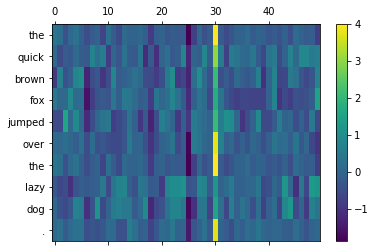

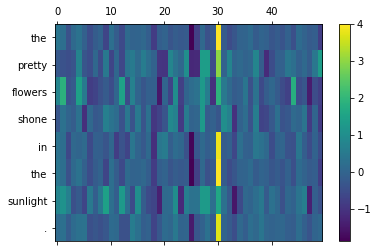

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [33]:



display_step = 10

def score_setup(row):
    convert_dict = {
      'ENTAILMENT': 0,
      'NEUTRAL': 1,
      'CONTRADICTION': 2
    }
    score = np.zeros((3,))
    tag = row["entailment_judgment"]
    score[convert_dict[tag]] += 1
    return score

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

In [82]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

training_iterations_count = 100000

lstm_size = hidden_size

weight_decay = 0.0005

learning_rate = 1

input_p, output_p = 0.6, 0.3

[Training data](http://www.site.uottawa.ca/~diana/csi5386/A2_2019/SICK_train.txt)

In [83]:
import numpy as np

def split_data_into_scores():
    import csv
    with open("data/training.txt","r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

### Cell used for development

In [86]:
def create_model():
    tf.reset_default_graph() 
    data_feature_list, correct_values, correct_scores = split_data_into_scores()

    l_h, l_e = max_hypothesis_length, max_evidence_length
    N, D, H = batch_size, vector_size, hidden_size
    l_seq = l_h + l_e
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)
    hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
    evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
    y = tf.placeholder(tf.float32, [N, 3], 'label')
    lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)

    lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)

    fc_initializer = tf.random_normal_initializer(stddev=0.1) 
    fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
    fc_bias = tf.get_variable('bias', [3])
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

    x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
    x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
    x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
    x = tf.split(x, l_seq,)
    rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)

    classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias

    with tf.variable_scope('Accuracy'):
        predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
        y_label = tf.cast(tf.argmax(y, 1), 'int32')
        corrects = tf.equal(predicts, y_label)
        num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
        accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

    with tf.variable_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
            logits = classification_scores, labels = y)
        loss = tf.reduce_mean(cross_entropy)
        total_loss = loss + weight_decay * tf.add_n(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    opt_op = optimizer.minimize(total_loss)
    # Initialize variables
    init = tf.global_variables_initializer()

    # Use TQDM if installed
    tqdm_installed = False
    try:
        from tqdm import tqdm
        tqdm_installed = True
    except:
        pass

    # Launch the Tensorflow session
    sess = tf.Session()
    sess.run(init)

    # training_iterations_count: The number of data pieces to train on in total
    # batch_size: The number of data pieces per batch
    training_iterations = range(0,training_iterations_count,batch_size)
    if tqdm_installed:
        # Add a progress bar if TQDM is installed
        training_iterations = tqdm(training_iterations)

    for i in training_iterations:
        if i % 1000 == 0:
        # Select indices for a random data subset
            batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)

        # Use the selected subset indices to initialize the graph's 
        #   placeholder values
        hyps, evis, ys = (data_feature_list[0][batch,:],
                          data_feature_list[1][batch,:],
                          correct_scores[batch])

        # Run the optimization with these initialized values
        sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
        # display_step: how often the accuracy and loss should 
        #   be tested and displayed.
        if (i/batch_size) % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
            # Calculate batch loss
            tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
            # Display results
            print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

    data_feature_list, correct_values, correct_scores = split_test_data_into_scores("data/dev.txt")


    hyps, evis, ys = (data_feature_list[0][:],
                      data_feature_list[1][:],
                      correct_scores)
    predictions = sess.run(classification_scores, feed_dict={hyp: hyps, evi: evis, y: ys})
    total = len(predictions)
    correct_predictions = 0
    for i,prediction in enumerate(predictions):
        if np.argmax(prediction[0])==np.argmax(ys[i]):
            correct_predictions += 1
    #     print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
    #       " / " + ["Positive", "Neutral", "Negative"][np.argmax(ys[i])])
    acc = correct_predictions*100/total
    print("Acc: %s" % str(acc))
    return acc

In [87]:
import numpy as np
accs = [] # 128
batches = [128, 64, 32, 1, 256]
for batch in batches:
    batch_size = batch
    accs.append(create_model())

print(accs)
print("Best batch size %s" % str(batches[np.argmax(accs)]))





  0%|                                                                          | 0/782 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 1.046311, Training Accuracy= 0.39844





  0%|                                                                  | 1/782 [00:03<39:48,  3.06s/it]


  1%|▎                                                                 | 4/782 [00:03<27:53,  2.15s/it]


  1%|▋                                                                 | 8/782 [00:03<19:32,  1.51s/it]

Iter 10.0, Minibatch Loss= 1.006866, Training Accuracy= 0.47656





  1%|▉                                                                | 11/782 [00:03<13:47,  1.07s/it]


  2%|█▏                                                               | 15/782 [00:03<09:43,  1.31it/s]


  2%|█▌                                                               | 19/782 [00:03<06:52,  1.85it/s]

Iter 20.0, Minibatch Loss= 1.030495, Training Accuracy= 0.46875





  3%|█▊                                                               | 22/782 [00:03<04:56,  2.56it/s]


  3%|██▏                                                              | 26/782 [00:03<03:32,  3.55it/s]


  4%|██▍                                                              | 30/782 [00:03<02:34,  4.86it/s]

Iter 30.0, Minibatch Loss= 0.998613, Training Accuracy= 0.50000





  4%|██▊                                                              | 34/782 [00:04<01:55,  6.46it/s]


  5%|███▏                                                             | 38/782 [00:04<01:26,  8.58it/s]

Iter 40.0, Minibatch Loss= 1.188272, Training Accuracy= 0.47656





  5%|███▍                                                             | 42/782 [00:04<01:08, 10.84it/s]


  6%|███▊                                                             | 46/782 [00:04<00:54, 13.58it/s]


  6%|████▏                                                            | 50/782 [00:04<00:44, 16.49it/s]

Iter 50.0, Minibatch Loss= 0.986133, Training Accuracy= 0.55469





  7%|████▍                                                            | 54/782 [00:04<00:41, 17.41it/s]


  7%|████▋                                                            | 57/782 [00:04<00:37, 19.57it/s]

Iter 60.0, Minibatch Loss= 1.038581, Training Accuracy= 0.46875





  8%|█████                                                            | 61/782 [00:05<00:34, 21.16it/s]


  8%|█████▍                                                           | 65/782 [00:05<00:30, 23.77it/s]


  9%|█████▋                                                           | 68/782 [00:05<00:30, 23.39it/s]

Iter 70.0, Minibatch Loss= 1.004398, Training Accuracy= 0.48438





  9%|█████▉                                                           | 71/782 [00:05<00:31, 22.76it/s]


 10%|██████▏                                                          | 75/782 [00:05<00:28, 25.06it/s]


 10%|██████▌                                                          | 79/782 [00:05<00:25, 27.19it/s]

Iter 80.0, Minibatch Loss= 1.010615, Training Accuracy= 0.46875





 10%|██████▊                                                          | 82/782 [00:05<00:27, 25.68it/s]


 11%|███████▏                                                         | 86/782 [00:05<00:25, 27.69it/s]


 12%|███████▍                                                         | 90/782 [00:06<00:23, 29.63it/s]

Iter 90.0, Minibatch Loss= 1.002805, Training Accuracy= 0.46875





 12%|███████▊                                                         | 94/782 [00:06<00:23, 29.63it/s]


 13%|████████▏                                                        | 98/782 [00:06<00:21, 31.45it/s]

Iter 100.0, Minibatch Loss= 0.968036, Training Accuracy= 0.53125





 13%|████████▎                                                       | 102/782 [00:06<00:22, 29.71it/s]


 14%|████████▋                                                       | 106/782 [00:06<00:21, 30.78it/s]


 14%|█████████                                                       | 110/782 [00:06<00:21, 31.58it/s]

Iter 110.0, Minibatch Loss= 0.988597, Training Accuracy= 0.52344





 15%|█████████▎                                                      | 114/782 [00:06<00:22, 30.06it/s]


 15%|█████████▋                                                      | 118/782 [00:06<00:21, 31.04it/s]

Iter 120.0, Minibatch Loss= 0.977643, Training Accuracy= 0.52344





 16%|█████████▉                                                      | 122/782 [00:07<00:21, 30.05it/s]


 16%|██████████▎                                                     | 126/782 [00:07<00:21, 31.19it/s]


 17%|██████████▋                                                     | 130/782 [00:07<00:20, 31.13it/s]

Iter 130.0, Minibatch Loss= 0.953897, Training Accuracy= 0.57812





 17%|██████████▉                                                     | 134/782 [00:07<00:22, 28.75it/s]


 18%|███████████▎                                                    | 138/782 [00:07<00:21, 30.05it/s]

Iter 140.0, Minibatch Loss= 0.942472, Training Accuracy= 0.58594





 18%|███████████▌                                                    | 142/782 [00:07<00:22, 27.86it/s]


 19%|███████████▉                                                    | 146/782 [00:07<00:21, 30.03it/s]


 19%|████████████▎                                                   | 150/782 [00:08<00:19, 31.68it/s]

Iter 150.0, Minibatch Loss= 0.928797, Training Accuracy= 0.59375





 20%|████████████▌                                                   | 154/782 [00:08<00:20, 31.04it/s]


 20%|████████████▉                                                   | 158/782 [00:08<00:19, 32.63it/s]

Iter 160.0, Minibatch Loss= 0.934262, Training Accuracy= 0.58594





 21%|█████████████▎                                                  | 162/782 [00:08<00:19, 31.74it/s]


 21%|█████████████▌                                                  | 166/782 [00:08<00:18, 33.00it/s]


 22%|█████████████▉                                                  | 170/782 [00:08<00:17, 34.20it/s]

Iter 170.0, Minibatch Loss= 0.954627, Training Accuracy= 0.57812





 22%|██████████████▏                                                 | 174/782 [00:08<00:19, 31.68it/s]


 23%|██████████████▌                                                 | 178/782 [00:08<00:18, 32.79it/s]

Iter 180.0, Minibatch Loss= 0.894737, Training Accuracy= 0.57812





 23%|██████████████▉                                                 | 182/782 [00:09<00:19, 30.96it/s]


 24%|███████████████▏                                                | 186/782 [00:09<00:18, 32.25it/s]


 24%|███████████████▌                                                | 190/782 [00:09<00:17, 33.55it/s]

Iter 190.0, Minibatch Loss= 0.995688, Training Accuracy= 0.57812





 25%|███████████████▉                                                | 194/782 [00:09<00:18, 31.58it/s]


 25%|████████████████▏                                               | 198/782 [00:09<00:18, 32.17it/s]

Iter 200.0, Minibatch Loss= 0.900557, Training Accuracy= 0.58594





 26%|████████████████▌                                               | 202/782 [00:09<00:18, 31.07it/s]


 26%|████████████████▊                                               | 206/782 [00:09<00:17, 32.41it/s]


 27%|█████████████████▏                                              | 210/782 [00:09<00:17, 32.36it/s]

Iter 210.0, Minibatch Loss= 1.035089, Training Accuracy= 0.45312





 27%|█████████████████▌                                              | 214/782 [00:10<00:18, 30.84it/s]


 28%|█████████████████▊                                              | 218/782 [00:10<00:17, 32.31it/s]

Iter 220.0, Minibatch Loss= 0.944693, Training Accuracy= 0.57812





 28%|██████████████████▏                                             | 222/782 [00:10<00:17, 31.53it/s]


 29%|██████████████████▍                                             | 226/782 [00:10<00:16, 33.17it/s]


 29%|██████████████████▊                                             | 230/782 [00:10<00:16, 34.07it/s]

Iter 230.0, Minibatch Loss= 0.985086, Training Accuracy= 0.57812





 30%|███████████████████▏                                            | 234/782 [00:10<00:17, 32.21it/s]


 30%|███████████████████▍                                            | 238/782 [00:10<00:16, 33.52it/s]

Iter 240.0, Minibatch Loss= 0.949658, Training Accuracy= 0.57812





 31%|███████████████████▊                                            | 242/782 [00:10<00:16, 32.25it/s]


 31%|████████████████████▏                                           | 246/782 [00:10<00:15, 33.64it/s]


 32%|████████████████████▍                                           | 250/782 [00:11<00:15, 34.50it/s]

Iter 250.0, Minibatch Loss= 0.934820, Training Accuracy= 0.54688





 32%|████████████████████▊                                           | 254/782 [00:11<00:16, 32.96it/s]


 33%|█████████████████████                                           | 258/782 [00:11<00:15, 34.17it/s]

Iter 260.0, Minibatch Loss= 0.941884, Training Accuracy= 0.53125





 34%|█████████████████████▍                                          | 262/782 [00:11<00:15, 32.83it/s]


 34%|█████████████████████▊                                          | 266/782 [00:11<00:15, 34.08it/s]


 35%|██████████████████████                                          | 270/782 [00:11<00:14, 34.82it/s]

Iter 270.0, Minibatch Loss= 0.923028, Training Accuracy= 0.54688





 35%|██████████████████████▍                                         | 274/782 [00:11<00:15, 32.84it/s]


 36%|██████████████████████▊                                         | 278/782 [00:11<00:14, 33.99it/s]

Iter 280.0, Minibatch Loss= 0.916794, Training Accuracy= 0.54688





 36%|███████████████████████                                         | 282/782 [00:12<00:17, 29.20it/s]


 37%|███████████████████████▍                                        | 286/782 [00:12<00:16, 29.20it/s]


 37%|███████████████████████▋                                        | 290/782 [00:12<00:16, 29.66it/s]

Iter 290.0, Minibatch Loss= 0.902774, Training Accuracy= 0.54688





 38%|████████████████████████                                        | 294/782 [00:12<00:17, 28.45it/s]


 38%|████████████████████████▍                                       | 298/782 [00:12<00:15, 30.43it/s]

Iter 300.0, Minibatch Loss= 0.984469, Training Accuracy= 0.51562





 39%|████████████████████████▋                                       | 302/782 [00:12<00:16, 29.92it/s]


 39%|█████████████████████████                                       | 306/782 [00:12<00:15, 31.22it/s]


 40%|█████████████████████████▎                                      | 310/782 [00:13<00:14, 32.52it/s]

Iter 310.0, Minibatch Loss= 0.923337, Training Accuracy= 0.54688





 40%|█████████████████████████▋                                      | 314/782 [00:13<00:15, 29.43it/s]


 41%|██████████████████████████                                      | 318/782 [00:13<00:15, 30.37it/s]

Iter 320.0, Minibatch Loss= 0.852724, Training Accuracy= 0.54688





 41%|██████████████████████████▎                                     | 322/782 [00:13<00:15, 29.03it/s]


 42%|██████████████████████████▋                                     | 326/782 [00:13<00:15, 30.33it/s]


 42%|███████████████████████████                                     | 330/782 [00:13<00:14, 31.85it/s]

Iter 330.0, Minibatch Loss= 0.944286, Training Accuracy= 0.54688





 43%|███████████████████████████▎                                    | 334/782 [00:13<00:14, 31.15it/s]


 43%|███████████████████████████▋                                    | 338/782 [00:13<00:13, 32.82it/s]

Iter 340.0, Minibatch Loss= 0.939195, Training Accuracy= 0.54688





 44%|███████████████████████████▉                                    | 342/782 [00:14<00:13, 31.97it/s]


 44%|████████████████████████████▎                                   | 346/782 [00:14<00:12, 33.98it/s]


 45%|████████████████████████████▋                                   | 350/782 [00:14<00:12, 34.31it/s]

Iter 350.0, Minibatch Loss= 0.938104, Training Accuracy= 0.54688





 45%|████████████████████████████▉                                   | 354/782 [00:14<00:13, 31.08it/s]


 46%|█████████████████████████████▎                                  | 358/782 [00:14<00:13, 31.27it/s]

Iter 360.0, Minibatch Loss= 0.937015, Training Accuracy= 0.54688





 46%|█████████████████████████████▋                                  | 362/782 [00:14<00:13, 30.62it/s]


 47%|█████████████████████████████▉                                  | 366/782 [00:14<00:13, 31.24it/s]


 47%|██████████████████████████████▎                                 | 370/782 [00:14<00:13, 31.32it/s]

Iter 370.0, Minibatch Loss= 0.935462, Training Accuracy= 0.54688





 48%|██████████████████████████████▌                                 | 374/782 [00:15<00:13, 29.96it/s]


 48%|██████████████████████████████▉                                 | 378/782 [00:15<00:12, 31.26it/s]

Iter 380.0, Minibatch Loss= 0.895507, Training Accuracy= 0.60938





 49%|███████████████████████████████▎                                | 382/782 [00:15<00:13, 29.08it/s]


 49%|███████████████████████████████▌                                | 385/782 [00:15<00:14, 28.35it/s]


 50%|███████████████████████████████▊                                | 389/782 [00:15<00:13, 28.85it/s]

Iter 390.0, Minibatch Loss= 0.885587, Training Accuracy= 0.61719





 50%|████████████████████████████████                                | 392/782 [00:15<00:15, 25.20it/s]


 51%|████████████████████████████████▎                               | 395/782 [00:15<00:14, 26.40it/s]


 51%|████████████████████████████████▌                               | 398/782 [00:15<00:14, 26.59it/s]

Iter 400.0, Minibatch Loss= 0.872792, Training Accuracy= 0.61719





 51%|████████████████████████████████▊                               | 401/782 [00:16<00:15, 24.61it/s]


 52%|█████████████████████████████████                               | 404/782 [00:16<00:15, 25.16it/s]


 52%|█████████████████████████████████▎                              | 407/782 [00:16<00:15, 24.44it/s]


 52%|█████████████████████████████████▌                              | 410/782 [00:16<00:14, 25.16it/s]

Iter 410.0, Minibatch Loss= 0.869730, Training Accuracy= 0.60938





 53%|█████████████████████████████████▊                              | 413/782 [00:16<00:16, 22.41it/s]


 53%|██████████████████████████████████▏                             | 417/782 [00:16<00:14, 24.76it/s]


 54%|██████████████████████████████████▎                             | 420/782 [00:16<00:14, 25.79it/s]

Iter 420.0, Minibatch Loss= 0.890985, Training Accuracy= 0.60938





 54%|██████████████████████████████████▌                             | 423/782 [00:17<00:14, 24.02it/s]


 54%|██████████████████████████████████▊                             | 426/782 [00:17<00:14, 24.19it/s]


 55%|███████████████████████████████████                             | 429/782 [00:17<00:14, 25.16it/s]

Iter 430.0, Minibatch Loss= 0.842923, Training Accuracy= 0.60938





 55%|███████████████████████████████████▎                            | 432/782 [00:17<00:14, 23.80it/s]


 56%|███████████████████████████████████▋                            | 436/782 [00:17<00:13, 25.63it/s]


 56%|███████████████████████████████████▉                            | 439/782 [00:17<00:13, 25.70it/s]

Iter 440.0, Minibatch Loss= 0.931465, Training Accuracy= 0.60156





 57%|████████████████████████████████████▏                           | 442/782 [00:17<00:13, 24.49it/s]


 57%|████████████████████████████████████▍                           | 445/782 [00:17<00:13, 25.78it/s]


 57%|████████████████████████████████████▋                           | 448/782 [00:17<00:12, 26.28it/s]

Iter 450.0, Minibatch Loss= 1.046192, Training Accuracy= 0.46875





 58%|████████████████████████████████████▉                           | 451/782 [00:18<00:13, 24.73it/s]


 58%|█████████████████████████████████████▏                          | 455/782 [00:18<00:12, 27.13it/s]


 59%|█████████████████████████████████████▍                          | 458/782 [00:18<00:12, 25.19it/s]

Iter 460.0, Minibatch Loss= 0.874843, Training Accuracy= 0.60938





 59%|█████████████████████████████████████▋                          | 461/782 [00:18<00:13, 24.45it/s]


 59%|██████████████████████████████████████                          | 465/782 [00:18<00:12, 25.65it/s]


 60%|██████████████████████████████████████▎                         | 468/782 [00:18<00:12, 25.26it/s]

Iter 470.0, Minibatch Loss= 0.869888, Training Accuracy= 0.60938





 60%|██████████████████████████████████████▌                         | 471/782 [00:18<00:13, 22.52it/s]


 61%|██████████████████████████████████████▊                         | 474/782 [00:19<00:12, 23.70it/s]


 61%|███████████████████████████████████████                         | 477/782 [00:19<00:12, 24.02it/s]


 61%|███████████████████████████████████████▎                        | 480/782 [00:19<00:12, 25.04it/s]

Iter 480.0, Minibatch Loss= 0.860514, Training Accuracy= 0.60938





 62%|███████████████████████████████████████▌                        | 483/782 [00:19<00:11, 25.47it/s]


 62%|███████████████████████████████████████▊                        | 487/782 [00:19<00:10, 27.92it/s]

Iter 490.0, Minibatch Loss= 0.846826, Training Accuracy= 0.60938





 63%|████████████████████████████████████████▏                       | 491/782 [00:19<00:10, 28.52it/s]


 63%|████████████████████████████████████████▌                       | 495/782 [00:19<00:09, 30.70it/s]


 64%|████████████████████████████████████████▊                       | 499/782 [00:19<00:08, 31.98it/s]

Iter 500.0, Minibatch Loss= 0.980472, Training Accuracy= 0.57031





 64%|█████████████████████████████████████████▏                      | 503/782 [00:19<00:08, 31.31it/s]


 65%|█████████████████████████████████████████▍                      | 507/782 [00:20<00:08, 32.67it/s]

Iter 510.0, Minibatch Loss= 0.946563, Training Accuracy= 0.57031





 65%|█████████████████████████████████████████▊                      | 511/782 [00:20<00:08, 31.77it/s]


 66%|██████████████████████████████████████████▏                     | 515/782 [00:20<00:08, 33.08it/s]


 66%|██████████████████████████████████████████▍                     | 519/782 [00:20<00:07, 33.08it/s]

Iter 520.0, Minibatch Loss= 0.915981, Training Accuracy= 0.57031





 67%|██████████████████████████████████████████▊                     | 523/782 [00:20<00:09, 27.26it/s]


 67%|███████████████████████████████████████████▏                    | 527/782 [00:20<00:09, 27.87it/s]


 68%|███████████████████████████████████████████▍                    | 530/782 [00:20<00:09, 27.01it/s]

Iter 530.0, Minibatch Loss= 0.889920, Training Accuracy= 0.57031





 68%|███████████████████████████████████████████▌                    | 533/782 [00:21<00:10, 24.87it/s]


 69%|███████████████████████████████████████████▉                    | 537/782 [00:21<00:09, 26.39it/s]

Iter 540.0, Minibatch Loss= 0.884960, Training Accuracy= 0.57031





 69%|████████████████████████████████████████████▎                   | 541/782 [00:21<00:08, 27.06it/s]


 70%|████████████████████████████████████████████▌                   | 545/782 [00:21<00:08, 28.80it/s]


 70%|████████████████████████████████████████████▉                   | 549/782 [00:21<00:07, 30.72it/s]

Iter 550.0, Minibatch Loss= 1.042768, Training Accuracy= 0.56250





 71%|█████████████████████████████████████████████▎                  | 553/782 [00:21<00:09, 23.00it/s]


 71%|█████████████████████████████████████████████▌                  | 556/782 [00:21<00:09, 23.56it/s]


 72%|█████████████████████████████████████████████▊                  | 560/782 [00:22<00:08, 25.49it/s]

Iter 560.0, Minibatch Loss= 0.976678, Training Accuracy= 0.57031





 72%|██████████████████████████████████████████████                  | 563/782 [00:22<00:08, 25.60it/s]


 73%|██████████████████████████████████████████████▍                 | 567/782 [00:22<00:07, 27.86it/s]

Iter 570.0, Minibatch Loss= 0.891604, Training Accuracy= 0.60156





 73%|██████████████████████████████████████████████▋                 | 571/782 [00:22<00:07, 28.37it/s]


 74%|███████████████████████████████████████████████                 | 575/782 [00:22<00:06, 29.69it/s]


 74%|███████████████████████████████████████████████▍                | 579/782 [00:22<00:06, 31.06it/s]

Iter 580.0, Minibatch Loss= 0.820257, Training Accuracy= 0.62500





 75%|███████████████████████████████████████████████▋                | 583/782 [00:22<00:07, 27.41it/s]


 75%|███████████████████████████████████████████████▉                | 586/782 [00:22<00:07, 26.71it/s]


 75%|████████████████████████████████████████████████▎               | 590/782 [00:23<00:06, 28.16it/s]

Iter 590.0, Minibatch Loss= 0.842359, Training Accuracy= 0.57812





 76%|████████████████████████████████████████████████▌               | 593/782 [00:23<00:07, 26.77it/s]


 76%|████████████████████████████████████████████████▊               | 597/782 [00:23<00:06, 28.94it/s]

Iter 600.0, Minibatch Loss= 0.850100, Training Accuracy= 0.58594





 77%|█████████████████████████████████████████████████▏              | 601/782 [00:23<00:06, 28.10it/s]


 77%|█████████████████████████████████████████████████▍              | 604/782 [00:23<00:06, 27.93it/s]


 78%|█████████████████████████████████████████████████▊              | 608/782 [00:23<00:05, 29.88it/s]

Iter 610.0, Minibatch Loss= 0.885810, Training Accuracy= 0.59375





 78%|██████████████████████████████████████████████████              | 612/782 [00:23<00:06, 27.81it/s]


 79%|██████████████████████████████████████████████████▍             | 616/782 [00:24<00:05, 29.53it/s]


 79%|██████████████████████████████████████████████████▋             | 620/782 [00:24<00:05, 31.00it/s]

Iter 620.0, Minibatch Loss= 0.991399, Training Accuracy= 0.51562





 80%|███████████████████████████████████████████████████             | 624/782 [00:24<00:05, 28.13it/s]


 80%|███████████████████████████████████████████████████▍            | 628/782 [00:24<00:05, 29.51it/s]

Iter 630.0, Minibatch Loss= 0.862071, Training Accuracy= 0.61719





 81%|███████████████████████████████████████████████████▋            | 632/782 [00:24<00:05, 28.66it/s]


 81%|████████████████████████████████████████████████████            | 636/782 [00:24<00:04, 29.92it/s]


 82%|████████████████████████████████████████████████████▍           | 640/782 [00:24<00:04, 31.60it/s]

Iter 640.0, Minibatch Loss= 0.781889, Training Accuracy= 0.66406





 82%|████████████████████████████████████████████████████▋           | 644/782 [00:24<00:04, 29.41it/s]


 83%|█████████████████████████████████████████████████████           | 648/782 [00:25<00:04, 30.77it/s]

Iter 650.0, Minibatch Loss= 0.808945, Training Accuracy= 0.62500





 83%|█████████████████████████████████████████████████████▎          | 652/782 [00:25<00:05, 25.62it/s]


 84%|█████████████████████████████████████████████████████▌          | 655/782 [00:25<00:04, 26.72it/s]


 84%|█████████████████████████████████████████████████████▊          | 658/782 [00:25<00:05, 21.69it/s]

Iter 660.0, Minibatch Loss= 1.031931, Training Accuracy= 0.60938





 85%|██████████████████████████████████████████████████████          | 661/782 [00:25<00:06, 19.10it/s]


 85%|██████████████████████████████████████████████████████▍         | 665/782 [00:25<00:05, 21.76it/s]


 86%|██████████████████████████████████████████████████████▊         | 669/782 [00:26<00:04, 24.95it/s]

Iter 670.0, Minibatch Loss= 0.879860, Training Accuracy= 0.60938





 86%|██████████████████████████████████████████████████████▉         | 672/782 [00:26<00:04, 25.06it/s]


 86%|███████████████████████████████████████████████████████▎        | 676/782 [00:26<00:03, 27.52it/s]


 87%|███████████████████████████████████████████████████████▋        | 680/782 [00:26<00:03, 29.75it/s]

Iter 680.0, Minibatch Loss= 0.837508, Training Accuracy= 0.61719





 87%|███████████████████████████████████████████████████████▉        | 684/782 [00:26<00:03, 30.54it/s]


 88%|████████████████████████████████████████████████████████▎       | 688/782 [00:26<00:02, 32.15it/s]

Iter 690.0, Minibatch Loss= 0.895742, Training Accuracy= 0.60156





 88%|████████████████████████████████████████████████████████▋       | 692/782 [00:26<00:02, 30.43it/s]


 89%|████████████████████████████████████████████████████████▉       | 696/782 [00:26<00:02, 30.81it/s]


 90%|█████████████████████████████████████████████████████████▎      | 700/782 [00:26<00:02, 32.29it/s]

Iter 700.0, Minibatch Loss= 0.754296, Training Accuracy= 0.67188





 90%|█████████████████████████████████████████████████████████▌      | 704/782 [00:27<00:02, 31.08it/s]


 91%|█████████████████████████████████████████████████████████▉      | 708/782 [00:27<00:02, 32.49it/s]

Iter 710.0, Minibatch Loss= 0.775030, Training Accuracy= 0.64062





 91%|██████████████████████████████████████████████████████████▎     | 712/782 [00:27<00:02, 31.28it/s]


 92%|██████████████████████████████████████████████████████████▌     | 716/782 [00:27<00:02, 32.41it/s]


 92%|██████████████████████████████████████████████████████████▉     | 720/782 [00:27<00:01, 33.76it/s]

Iter 720.0, Minibatch Loss= 0.641636, Training Accuracy= 0.70312





 93%|███████████████████████████████████████████████████████████▎    | 724/782 [00:27<00:01, 32.56it/s]


 93%|███████████████████████████████████████████████████████████▋    | 729/782 [00:27<00:01, 34.03it/s]

Iter 730.0, Minibatch Loss= 0.678659, Training Accuracy= 0.71875





 94%|███████████████████████████████████████████████████████████▉    | 733/782 [00:27<00:01, 32.60it/s]


 94%|████████████████████████████████████████████████████████████▍   | 738/782 [00:28<00:01, 33.88it/s]

Iter 740.0, Minibatch Loss= 0.881326, Training Accuracy= 0.62500





 95%|████████████████████████████████████████████████████████████▋   | 742/782 [00:28<00:01, 32.27it/s]


 95%|█████████████████████████████████████████████████████████████   | 746/782 [00:28<00:01, 33.48it/s]


 96%|█████████████████████████████████████████████████████████████▍  | 750/782 [00:28<00:00, 34.21it/s]

Iter 750.0, Minibatch Loss= 1.009959, Training Accuracy= 0.55469





 96%|█████████████████████████████████████████████████████████████▋  | 754/782 [00:28<00:00, 33.61it/s]


 97%|██████████████████████████████████████████████████████████████  | 758/782 [00:28<00:00, 32.99it/s]

Iter 760.0, Minibatch Loss= 0.902957, Training Accuracy= 0.60156





 97%|██████████████████████████████████████████████████████████████▎ | 762/782 [00:28<00:00, 31.83it/s]


 98%|██████████████████████████████████████████████████████████████▋ | 766/782 [00:28<00:00, 33.21it/s]


 98%|███████████████████████████████████████████████████████████████ | 770/782 [00:29<00:00, 32.68it/s]

Iter 770.0, Minibatch Loss= 0.971054, Training Accuracy= 0.55469





 99%|███████████████████████████████████████████████████████████████▎| 774/782 [00:29<00:00, 32.03it/s]


 99%|███████████████████████████████████████████████████████████████▋| 778/782 [00:29<00:00, 32.23it/s]

Iter 780.0, Minibatch Loss= 0.936251, Training Accuracy= 0.55469





100%|████████████████████████████████████████████████████████████████| 782/782 [00:29<00:00, 31.56it/s]

ValueError: Cannot feed value of shape (500, 30, 50) for Tensor 'hypothesis:0', which has shape '(128, 30, 50)'

### TRAINING

In [75]:
tf.reset_default_graph()

In [76]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [77]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
# lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)

# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In [78]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)



 59%|████████████████████████████████████▊                         | 2319/3907 [01:26<00:47, 33.30it/s]

In [79]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
# tqdm_installed = False
# try:
#     from tqdm import tqdm
#     tqdm_installed = True
# except:
#     pass

from tqdm import tqdm

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:
    if i % 1000 == 0:
    # Select indices for a random data subset
        batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))




  0%|                                                                         | 0/3907 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 0.966199, Training Accuracy= 0.56250





  0%|                                                               | 1/3907 [00:02<2:47:48,  2.58s/it]


  0%|                                                               | 5/3907 [00:02<1:57:53,  1.81s/it]


  0%|▏                                                              | 9/3907 [00:02<1:23:03,  1.28s/it]

Iter 10.0, Minibatch Loss= 0.961610, Training Accuracy= 0.56250





  0%|▏                                                               | 12/3907 [00:02<58:47,  1.10it/s]


  0%|▎                                                               | 16/3907 [00:03<41:37,  1.56it/s]

Iter 20.0, Minibatch Loss= 0.956930, Training Accuracy= 0.56250





  1%|▎                                                               | 21/3907 [00:03<29:43,  2.18it/s]


  1%|▍                                                               | 25/3907 [00:03<21:18,  3.04it/s]


  1%|▍                                                               | 29/3907 [00:03<15:25,  4.19it/s]

Iter 30.0, Minibatch Loss= 0.939648, Training Accuracy= 0.56250





  1%|▌                                                               | 33/3907 [00:03<11:24,  5.66it/s]


  1%|▌                                                               | 37/3907 [00:03<08:31,  7.57it/s]

Iter 40.0, Minibatch Loss= 0.958017, Training Accuracy= 0.56250





  1%|▋                                                               | 41/3907 [00:03<06:35,  9.78it/s]


  1%|▋                                                               | 45/3907 [00:03<05:11, 12.41it/s]


  1%|▊                                                               | 49/3907 [00:04<04:11, 15.33it/s]

Iter 50.0, Minibatch Loss= 0.989486, Training Accuracy= 0.56250





  1%|▊                                                               | 53/3907 [00:04<03:41, 17.39it/s]


  1%|▉                                                               | 57/3907 [00:04<03:07, 20.52it/s]

Iter 60.0, Minibatch Loss= 0.955909, Training Accuracy= 0.56250





  2%|▉                                                               | 61/3907 [00:04<02:49, 22.70it/s]


  2%|█                                                               | 65/3907 [00:04<02:32, 25.12it/s]


  2%|█▏                                                              | 69/3907 [00:04<02:18, 27.73it/s]

Iter 70.0, Minibatch Loss= 0.959343, Training Accuracy= 0.56250





  2%|█▏                                                              | 73/3907 [00:04<02:15, 28.28it/s]


  2%|█▎                                                              | 77/3907 [00:04<02:03, 31.00it/s]

Iter 80.0, Minibatch Loss= 0.942271, Training Accuracy= 0.56250





  2%|█▎                                                              | 81/3907 [00:05<02:05, 30.61it/s]


  2%|█▍                                                              | 85/3907 [00:05<01:59, 31.86it/s]


  2%|█▍                                                              | 89/3907 [00:05<01:57, 32.61it/s]

Iter 90.0, Minibatch Loss= 1.007644, Training Accuracy= 0.56250





  2%|█▌                                                              | 93/3907 [00:05<01:56, 32.78it/s]


  2%|█▌                                                              | 97/3907 [00:05<01:53, 33.51it/s]

Iter 100.0, Minibatch Loss= 0.922441, Training Accuracy= 0.56250





  3%|█▋                                                             | 101/3907 [00:05<01:58, 32.19it/s]


  3%|█▋                                                             | 105/3907 [00:05<01:55, 32.84it/s]


  3%|█▊                                                             | 109/3907 [00:05<01:58, 32.11it/s]

Iter 110.0, Minibatch Loss= 0.967448, Training Accuracy= 0.46094





  3%|█▊                                                             | 113/3907 [00:06<02:12, 28.63it/s]


  3%|█▉                                                             | 117/3907 [00:06<02:08, 29.57it/s]

Iter 120.0, Minibatch Loss= 0.948647, Training Accuracy= 0.56250





  3%|█▉                                                             | 121/3907 [00:06<02:11, 28.82it/s]


  3%|██                                                             | 125/3907 [00:06<02:20, 26.91it/s]


  3%|██                                                             | 128/3907 [00:06<02:21, 26.78it/s]

Iter 130.0, Minibatch Loss= 0.923134, Training Accuracy= 0.57812





  3%|██                                                             | 131/3907 [00:06<02:19, 27.13it/s]


  3%|██▏                                                            | 135/3907 [00:06<02:12, 28.54it/s]


  4%|██▏                                                            | 139/3907 [00:06<02:01, 30.95it/s]

Iter 140.0, Minibatch Loss= 0.933338, Training Accuracy= 0.59375





  4%|██▎                                                            | 143/3907 [00:07<02:03, 30.42it/s]


  4%|██▎                                                            | 147/3907 [00:07<01:59, 31.48it/s]

Iter 150.0, Minibatch Loss= 0.950265, Training Accuracy= 0.57812





  4%|██▍                                                            | 151/3907 [00:07<02:00, 31.19it/s]


  4%|██▍                                                            | 155/3907 [00:07<01:56, 32.10it/s]


  4%|██▌                                                            | 159/3907 [00:07<01:56, 32.13it/s]

Iter 160.0, Minibatch Loss= 0.903352, Training Accuracy= 0.57812





  4%|██▋                                                            | 163/3907 [00:07<02:02, 30.65it/s]


  4%|██▋                                                            | 167/3907 [00:07<02:00, 30.95it/s]

Iter 170.0, Minibatch Loss= 0.871095, Training Accuracy= 0.57812





  4%|██▊                                                            | 171/3907 [00:07<01:58, 31.65it/s]


  4%|██▊                                                            | 175/3907 [00:08<01:59, 31.11it/s]


  5%|██▉                                                            | 179/3907 [00:08<01:56, 32.08it/s]

Iter 180.0, Minibatch Loss= 0.863176, Training Accuracy= 0.64062





  5%|██▉                                                            | 183/3907 [00:08<02:02, 30.52it/s]


  5%|███                                                            | 187/3907 [00:08<01:54, 32.39it/s]

Iter 190.0, Minibatch Loss= 0.936886, Training Accuracy= 0.57812





  5%|███                                                            | 191/3907 [00:08<02:25, 25.57it/s]


  5%|███▏                                                           | 195/3907 [00:08<02:14, 27.58it/s]


  5%|███▏                                                           | 199/3907 [00:08<02:06, 29.28it/s]

Iter 200.0, Minibatch Loss= 0.907445, Training Accuracy= 0.57812





  5%|███▎                                                           | 203/3907 [00:09<02:06, 29.36it/s]


  5%|███▎                                                           | 207/3907 [00:09<02:04, 29.80it/s]

Iter 210.0, Minibatch Loss= 0.887922, Training Accuracy= 0.61719





  5%|███▍                                                           | 211/3907 [00:09<02:03, 30.01it/s]


  6%|███▍                                                           | 215/3907 [00:09<01:59, 30.97it/s]


  6%|███▌                                                           | 219/3907 [00:09<01:57, 31.35it/s]

Iter 220.0, Minibatch Loss= 1.014011, Training Accuracy= 0.29688





  6%|███▌                                                           | 223/3907 [00:09<02:02, 30.18it/s]


  6%|███▋                                                           | 227/3907 [00:09<02:03, 29.82it/s]

Iter 230.0, Minibatch Loss= 0.934448, Training Accuracy= 0.57812





  6%|███▋                                                           | 231/3907 [00:09<02:06, 29.06it/s]


  6%|███▊                                                           | 235/3907 [00:10<02:00, 30.51it/s]


  6%|███▊                                                           | 240/3907 [00:10<01:53, 32.23it/s]

Iter 240.0, Minibatch Loss= 0.929026, Training Accuracy= 0.57812





  6%|███▉                                                           | 244/3907 [00:10<01:54, 31.97it/s]


  6%|███▉                                                           | 248/3907 [00:10<01:53, 32.31it/s]

Iter 250.0, Minibatch Loss= 0.999444, Training Accuracy= 0.59375





  6%|████                                                           | 252/3907 [00:10<01:56, 31.48it/s]


  7%|████▏                                                          | 256/3907 [00:10<01:48, 33.62it/s]


  7%|████▏                                                          | 260/3907 [00:10<01:47, 34.02it/s]

Iter 260.0, Minibatch Loss= 0.940513, Training Accuracy= 0.59375





  7%|████▎                                                          | 264/3907 [00:10<01:51, 32.80it/s]


  7%|████▎                                                          | 268/3907 [00:11<02:16, 26.75it/s]

Iter 270.0, Minibatch Loss= 0.939447, Training Accuracy= 0.59375





  7%|████▎                                                          | 271/3907 [00:11<02:18, 26.33it/s]


  7%|████▍                                                          | 275/3907 [00:11<02:07, 28.59it/s]


  7%|████▍                                                          | 279/3907 [00:11<01:58, 30.62it/s]

Iter 280.0, Minibatch Loss= 0.936342, Training Accuracy= 0.59375





  7%|████▌                                                          | 283/3907 [00:11<01:59, 30.31it/s]


  7%|████▋                                                          | 287/3907 [00:11<01:53, 31.83it/s]

Iter 290.0, Minibatch Loss= 0.971939, Training Accuracy= 0.59375





  7%|████▋                                                          | 291/3907 [00:11<01:55, 31.28it/s]


  8%|████▊                                                          | 295/3907 [00:12<01:50, 32.73it/s]


  8%|████▊                                                          | 299/3907 [00:12<01:45, 34.09it/s]

Iter 300.0, Minibatch Loss= 0.937777, Training Accuracy= 0.59375





  8%|████▉                                                          | 303/3907 [00:12<01:50, 32.70it/s]


  8%|████▉                                                          | 307/3907 [00:12<01:44, 34.40it/s]

Iter 310.0, Minibatch Loss= 0.925278, Training Accuracy= 0.59375





  8%|█████                                                          | 311/3907 [00:12<01:50, 32.68it/s]


  8%|█████                                                          | 315/3907 [00:12<01:47, 33.33it/s]


  8%|█████▏                                                         | 319/3907 [00:12<01:45, 34.01it/s]

Iter 320.0, Minibatch Loss= 0.924451, Training Accuracy= 0.59375





  8%|█████▏                                                         | 323/3907 [00:12<01:51, 32.25it/s]


  8%|█████▎                                                         | 327/3907 [00:12<01:49, 32.57it/s]

Iter 330.0, Minibatch Loss= 0.933681, Training Accuracy= 0.59375





  8%|█████▎                                                         | 331/3907 [00:13<01:54, 31.33it/s]


  9%|█████▍                                                         | 335/3907 [00:13<01:51, 31.98it/s]


  9%|█████▍                                                         | 339/3907 [00:13<01:51, 32.06it/s]

Iter 340.0, Minibatch Loss= 0.918554, Training Accuracy= 0.59375





  9%|█████▌                                                         | 343/3907 [00:13<01:54, 31.07it/s]


  9%|█████▌                                                         | 347/3907 [00:13<01:50, 32.10it/s]

Iter 350.0, Minibatch Loss= 0.925559, Training Accuracy= 0.59375





  9%|█████▋                                                         | 351/3907 [00:13<01:53, 31.39it/s]


  9%|█████▋                                                         | 355/3907 [00:13<01:51, 31.87it/s]


  9%|█████▊                                                         | 359/3907 [00:13<01:49, 32.45it/s]

Iter 360.0, Minibatch Loss= 0.913809, Training Accuracy= 0.59375





  9%|█████▊                                                         | 363/3907 [00:14<01:52, 31.48it/s]


  9%|█████▉                                                         | 367/3907 [00:14<01:47, 32.88it/s]

Iter 370.0, Minibatch Loss= 0.911105, Training Accuracy= 0.59375





  9%|█████▉                                                         | 371/3907 [00:14<01:51, 31.61it/s]


 10%|██████                                                         | 375/3907 [00:14<01:52, 31.50it/s]


 10%|██████                                                         | 379/3907 [00:14<01:49, 32.18it/s]

Iter 380.0, Minibatch Loss= 0.923065, Training Accuracy= 0.57812





 10%|██████▏                                                        | 383/3907 [00:14<01:54, 30.65it/s]


 10%|██████▏                                                        | 387/3907 [00:14<01:52, 31.41it/s]

Iter 390.0, Minibatch Loss= 0.913354, Training Accuracy= 0.57812





 10%|██████▎                                                        | 391/3907 [00:15<01:55, 30.57it/s]


 10%|██████▎                                                        | 395/3907 [00:15<01:55, 30.49it/s]


 10%|██████▍                                                        | 399/3907 [00:15<01:49, 31.97it/s]

Iter 400.0, Minibatch Loss= 0.896837, Training Accuracy= 0.57812





 10%|██████▍                                                        | 403/3907 [00:15<01:53, 30.87it/s]


 10%|██████▌                                                        | 407/3907 [00:15<01:48, 32.25it/s]

Iter 410.0, Minibatch Loss= 1.044695, Training Accuracy= 0.55469





 11%|██████▋                                                        | 411/3907 [00:15<01:52, 31.20it/s]


 11%|██████▋                                                        | 415/3907 [00:15<01:47, 32.51it/s]


 11%|██████▊                                                        | 419/3907 [00:15<01:45, 33.08it/s]

Iter 420.0, Minibatch Loss= 0.926977, Training Accuracy= 0.57812





 11%|██████▊                                                        | 423/3907 [00:16<01:59, 29.16it/s]


 11%|██████▉                                                        | 427/3907 [00:16<01:54, 30.30it/s]

Iter 430.0, Minibatch Loss= 0.909146, Training Accuracy= 0.57812





 11%|██████▉                                                        | 431/3907 [00:16<02:00, 28.73it/s]


 11%|███████                                                        | 435/3907 [00:16<01:55, 30.18it/s]


 11%|███████                                                        | 439/3907 [00:16<01:51, 31.06it/s]

Iter 440.0, Minibatch Loss= 0.828125, Training Accuracy= 0.59375





 11%|███████▏                                                       | 443/3907 [00:16<02:01, 28.40it/s]


 11%|███████▏                                                       | 447/3907 [00:16<01:57, 29.39it/s]

Iter 450.0, Minibatch Loss= 0.927211, Training Accuracy= 0.57812





 12%|███████▎                                                       | 451/3907 [00:16<01:59, 28.89it/s]


 12%|███████▎                                                       | 455/3907 [00:17<01:54, 30.16it/s]


 12%|███████▍                                                       | 459/3907 [00:17<01:50, 31.34it/s]

Iter 460.0, Minibatch Loss= 0.906284, Training Accuracy= 0.57812





 12%|███████▍                                                       | 463/3907 [00:17<02:03, 27.90it/s]


 12%|███████▌                                                       | 467/3907 [00:17<01:55, 29.66it/s]

Iter 470.0, Minibatch Loss= 0.891201, Training Accuracy= 0.57812





 12%|███████▌                                                       | 471/3907 [00:17<02:00, 28.57it/s]


 12%|███████▋                                                       | 475/3907 [00:17<01:52, 30.61it/s]


 12%|███████▋                                                       | 479/3907 [00:17<01:47, 31.75it/s]

Iter 480.0, Minibatch Loss= 0.980177, Training Accuracy= 0.57812





 12%|███████▊                                                       | 483/3907 [00:18<01:50, 30.87it/s]


 12%|███████▊                                                       | 487/3907 [00:18<01:45, 32.33it/s]

Iter 490.0, Minibatch Loss= 0.869046, Training Accuracy= 0.58594





 13%|███████▉                                                       | 491/3907 [00:18<01:48, 31.55it/s]


 13%|███████▉                                                       | 495/3907 [00:18<01:43, 32.85it/s]


 13%|████████                                                       | 499/3907 [00:18<01:41, 33.58it/s]

Iter 500.0, Minibatch Loss= 0.989536, Training Accuracy= 0.51562





 13%|████████                                                       | 503/3907 [00:18<01:42, 33.19it/s]


 13%|████████▏                                                      | 507/3907 [00:18<01:42, 33.31it/s]

Iter 510.0, Minibatch Loss= 0.950534, Training Accuracy= 0.57031





 13%|████████▏                                                      | 511/3907 [00:18<01:45, 32.19it/s]


 13%|████████▎                                                      | 515/3907 [00:18<01:41, 33.34it/s]


 13%|████████▎                                                      | 519/3907 [00:19<01:36, 35.07it/s]

Iter 520.0, Minibatch Loss= 0.888959, Training Accuracy= 0.53125





 13%|████████▍                                                      | 523/3907 [00:19<01:42, 32.86it/s]


 13%|████████▍                                                      | 527/3907 [00:19<01:39, 33.81it/s]

Iter 530.0, Minibatch Loss= 0.881234, Training Accuracy= 0.60156





 14%|████████▌                                                      | 531/3907 [00:19<01:51, 30.33it/s]


 14%|████████▋                                                      | 535/3907 [00:19<01:47, 31.39it/s]


 14%|████████▋                                                      | 539/3907 [00:19<01:42, 32.81it/s]

Iter 540.0, Minibatch Loss= 0.762118, Training Accuracy= 0.61719





 14%|████████▊                                                      | 543/3907 [00:19<01:47, 31.41it/s]


 14%|████████▊                                                      | 547/3907 [00:19<01:44, 32.20it/s]

Iter 550.0, Minibatch Loss= 0.911667, Training Accuracy= 0.52344





 14%|████████▉                                                      | 551/3907 [00:20<01:47, 31.31it/s]


 14%|████████▉                                                      | 555/3907 [00:20<01:43, 32.28it/s]


 14%|█████████                                                      | 559/3907 [00:20<01:40, 33.32it/s]

Iter 560.0, Minibatch Loss= 0.862327, Training Accuracy= 0.49219





 14%|█████████                                                      | 563/3907 [00:20<01:44, 32.04it/s]


 15%|█████████▏                                                     | 567/3907 [00:20<01:40, 33.14it/s]

Iter 570.0, Minibatch Loss= 0.971205, Training Accuracy= 0.56250





 15%|█████████▏                                                     | 571/3907 [00:20<01:46, 31.33it/s]


 15%|█████████▎                                                     | 575/3907 [00:20<01:53, 29.31it/s]


 15%|█████████▎                                                     | 579/3907 [00:21<01:47, 30.98it/s]

Iter 580.0, Minibatch Loss= 0.876812, Training Accuracy= 0.57812





 15%|█████████▍                                                     | 583/3907 [00:21<01:51, 29.74it/s]


 15%|█████████▍                                                     | 587/3907 [00:21<01:45, 31.53it/s]

Iter 590.0, Minibatch Loss= 0.753269, Training Accuracy= 0.66406





 15%|█████████▌                                                     | 591/3907 [00:21<01:48, 30.44it/s]


 15%|█████████▌                                                     | 595/3907 [00:21<01:44, 31.70it/s]


 15%|█████████▋                                                     | 599/3907 [00:21<01:46, 30.98it/s]

Iter 600.0, Minibatch Loss= 0.902380, Training Accuracy= 0.59375





 15%|█████████▋                                                     | 603/3907 [00:21<01:51, 29.74it/s]


 16%|█████████▊                                                     | 607/3907 [00:21<01:46, 31.09it/s]

Iter 610.0, Minibatch Loss= 0.906308, Training Accuracy= 0.59375





 16%|█████████▊                                                     | 611/3907 [00:22<01:49, 30.22it/s]


 16%|█████████▉                                                     | 615/3907 [00:22<01:44, 31.61it/s]


 16%|█████████▉                                                     | 619/3907 [00:22<01:39, 32.90it/s]

Iter 620.0, Minibatch Loss= 0.898161, Training Accuracy= 0.59375





 16%|██████████                                                     | 623/3907 [00:22<01:45, 31.25it/s]


 16%|██████████                                                     | 627/3907 [00:22<01:46, 30.67it/s]

Iter 630.0, Minibatch Loss= 0.955622, Training Accuracy= 0.56250





 16%|██████████▏                                                    | 631/3907 [00:22<01:49, 29.94it/s]


 16%|██████████▏                                                    | 635/3907 [00:22<01:44, 31.25it/s]


 16%|██████████▎                                                    | 639/3907 [00:22<01:42, 31.92it/s]

Iter 640.0, Minibatch Loss= 0.936733, Training Accuracy= 0.56250





 16%|██████████▎                                                    | 643/3907 [00:23<01:47, 30.41it/s]


 17%|██████████▍                                                    | 647/3907 [00:23<01:46, 30.52it/s]

Iter 650.0, Minibatch Loss= 0.893308, Training Accuracy= 0.56250





 17%|██████████▍                                                    | 651/3907 [00:23<01:48, 30.04it/s]


 17%|██████████▌                                                    | 655/3907 [00:23<01:43, 31.47it/s]


 17%|██████████▋                                                    | 659/3907 [00:23<01:39, 32.72it/s]

Iter 660.0, Minibatch Loss= 0.952935, Training Accuracy= 0.56250





 17%|██████████▋                                                    | 663/3907 [00:23<01:46, 30.42it/s]


 17%|██████████▊                                                    | 667/3907 [00:23<01:44, 30.88it/s]

Iter 670.0, Minibatch Loss= 0.877581, Training Accuracy= 0.56250





 17%|██████████▊                                                    | 671/3907 [00:24<01:49, 29.55it/s]


 17%|██████████▉                                                    | 675/3907 [00:24<01:46, 30.45it/s]


 17%|██████████▉                                                    | 679/3907 [00:24<01:42, 31.48it/s]

Iter 680.0, Minibatch Loss= 0.912981, Training Accuracy= 0.56250





 17%|███████████                                                    | 683/3907 [00:24<01:49, 29.34it/s]


 18%|███████████                                                    | 686/3907 [00:24<01:50, 29.10it/s]


 18%|███████████▏                                                   | 690/3907 [00:24<01:45, 30.60it/s]

Iter 690.0, Minibatch Loss= 0.853112, Training Accuracy= 0.62500





 18%|███████████▏                                                   | 694/3907 [00:24<01:48, 29.70it/s]


 18%|███████████▎                                                   | 698/3907 [00:24<01:45, 30.42it/s]

Iter 700.0, Minibatch Loss= 0.937636, Training Accuracy= 0.57031





 18%|███████████▎                                                   | 702/3907 [00:25<01:52, 28.38it/s]


 18%|███████████▍                                                   | 706/3907 [00:25<01:47, 29.78it/s]


 18%|███████████▍                                                   | 710/3907 [00:25<01:47, 29.87it/s]

Iter 710.0, Minibatch Loss= 0.928312, Training Accuracy= 0.57031





 18%|███████████▌                                                   | 714/3907 [00:25<01:49, 29.21it/s]


 18%|███████████▌                                                   | 718/3907 [00:25<01:43, 30.90it/s]

Iter 720.0, Minibatch Loss= 0.818853, Training Accuracy= 0.64062





 18%|███████████▋                                                   | 722/3907 [00:25<01:53, 28.13it/s]


 19%|███████████▋                                                   | 726/3907 [00:25<01:46, 29.77it/s]


 19%|███████████▊                                                   | 730/3907 [00:25<01:44, 30.34it/s]

Iter 730.0, Minibatch Loss= 0.857047, Training Accuracy= 0.61719





 19%|███████████▊                                                   | 734/3907 [00:26<01:52, 28.21it/s]


 19%|███████████▉                                                   | 738/3907 [00:26<01:47, 29.44it/s]

Iter 740.0, Minibatch Loss= 0.911582, Training Accuracy= 0.58594





 19%|███████████▉                                                   | 742/3907 [00:26<01:48, 29.11it/s]


 19%|████████████                                                   | 746/3907 [00:26<01:42, 30.89it/s]


 19%|████████████                                                   | 750/3907 [00:26<01:41, 31.00it/s]

Iter 750.0, Minibatch Loss= 1.013099, Training Accuracy= 0.54688





 19%|████████████▏                                                  | 754/3907 [00:26<01:45, 29.89it/s]


 19%|████████████▏                                                  | 758/3907 [00:26<01:44, 30.22it/s]

Iter 760.0, Minibatch Loss= 1.002923, Training Accuracy= 0.50781





 20%|████████████▎                                                  | 762/3907 [00:27<01:50, 28.44it/s]


 20%|████████████▎                                                  | 765/3907 [00:27<01:51, 28.24it/s]


 20%|████████████▍                                                  | 769/3907 [00:27<01:44, 30.13it/s]

Iter 770.0, Minibatch Loss= 0.971610, Training Accuracy= 0.51562





 20%|████████████▍                                                  | 773/3907 [00:27<01:50, 28.32it/s]


 20%|████████████▌                                                  | 776/3907 [00:27<01:55, 27.02it/s]


 20%|████████████▌                                                  | 780/3907 [00:27<01:49, 28.52it/s]

Iter 780.0, Minibatch Loss= 0.784665, Training Accuracy= 0.65625





 20%|████████████▋                                                  | 783/3907 [00:27<01:57, 26.50it/s]


 20%|████████████▋                                                  | 786/3907 [00:27<01:55, 27.09it/s]


 20%|████████████▋                                                  | 789/3907 [00:28<01:57, 26.49it/s]

Iter 790.0, Minibatch Loss= 1.067019, Training Accuracy= 0.45312





 20%|████████████▊                                                  | 792/3907 [00:28<02:00, 25.89it/s]


 20%|████████████▊                                                  | 796/3907 [00:28<01:50, 28.22it/s]


 20%|████████████▉                                                  | 800/3907 [00:28<01:44, 29.78it/s]

Iter 800.0, Minibatch Loss= 0.897316, Training Accuracy= 0.63281





 21%|████████████▉                                                  | 804/3907 [00:28<01:54, 27.13it/s]


 21%|█████████████                                                  | 808/3907 [00:28<01:46, 29.11it/s]

Iter 810.0, Minibatch Loss= 0.834403, Training Accuracy= 0.56250





 21%|█████████████                                                  | 812/3907 [00:28<01:47, 28.82it/s]


 21%|█████████████▏                                                 | 816/3907 [00:28<01:41, 30.31it/s]


 21%|█████████████▏                                                 | 820/3907 [00:29<01:37, 31.52it/s]

Iter 820.0, Minibatch Loss= 1.125449, Training Accuracy= 0.44531





 21%|█████████████▎                                                 | 824/3907 [00:29<01:42, 30.11it/s]


 21%|█████████████▎                                                 | 828/3907 [00:29<01:40, 30.66it/s]

Iter 830.0, Minibatch Loss= 0.865268, Training Accuracy= 0.56250





 21%|█████████████▍                                                 | 832/3907 [00:29<01:47, 28.65it/s]


 21%|█████████████▍                                                 | 836/3907 [00:29<01:38, 31.14it/s]


 21%|█████████████▌                                                 | 840/3907 [00:29<01:38, 31.12it/s]

Iter 840.0, Minibatch Loss= 0.989989, Training Accuracy= 0.53125





 22%|█████████████▌                                                 | 844/3907 [00:29<01:47, 28.39it/s]


 22%|█████████████▋                                                 | 847/3907 [00:30<01:50, 27.59it/s]

Iter 850.0, Minibatch Loss= 0.954126, Training Accuracy= 0.46094





 22%|█████████████▋                                                 | 851/3907 [00:30<01:53, 26.84it/s]


 22%|█████████████▊                                                 | 855/3907 [00:30<01:44, 29.15it/s]


 22%|█████████████▊                                                 | 859/3907 [00:30<01:46, 28.55it/s]

Iter 860.0, Minibatch Loss= 0.882171, Training Accuracy= 0.57031





 22%|█████████████▉                                                 | 862/3907 [00:30<01:55, 26.45it/s]


 22%|█████████████▉                                                 | 865/3907 [00:30<01:53, 26.78it/s]


 22%|██████████████                                                 | 869/3907 [00:30<01:44, 29.16it/s]

Iter 870.0, Minibatch Loss= 0.849490, Training Accuracy= 0.59375





 22%|██████████████                                                 | 873/3907 [00:30<01:51, 27.15it/s]


 22%|██████████████▏                                                | 877/3907 [00:31<01:43, 29.23it/s]

Iter 880.0, Minibatch Loss= 0.772388, Training Accuracy= 0.64844





 23%|██████████████▏                                                | 881/3907 [00:31<01:45, 28.56it/s]


 23%|██████████████▎                                                | 885/3907 [00:31<01:44, 28.83it/s]


 23%|██████████████▎                                                | 889/3907 [00:31<01:41, 29.78it/s]

Iter 890.0, Minibatch Loss= 0.809863, Training Accuracy= 0.64844





 23%|██████████████▍                                                | 893/3907 [00:31<01:47, 28.11it/s]


 23%|██████████████▍                                                | 897/3907 [00:31<01:40, 29.89it/s]

Iter 900.0, Minibatch Loss= 0.735309, Training Accuracy= 0.64844





 23%|██████████████▌                                                | 901/3907 [00:31<01:43, 28.97it/s]


 23%|██████████████▌                                                | 905/3907 [00:32<01:41, 29.55it/s]


 23%|██████████████▋                                                | 908/3907 [00:32<01:41, 29.42it/s]

Iter 910.0, Minibatch Loss= 0.714465, Training Accuracy= 0.66406





 23%|██████████████▋                                                | 911/3907 [00:32<01:51, 26.89it/s]


 23%|██████████████▊                                                | 915/3907 [00:32<01:46, 28.18it/s]


 24%|██████████████▊                                                | 919/3907 [00:32<01:39, 29.88it/s]

Iter 920.0, Minibatch Loss= 0.735558, Training Accuracy= 0.66406





 24%|██████████████▉                                                | 923/3907 [00:32<01:42, 29.22it/s]


 24%|██████████████▉                                                | 927/3907 [00:32<01:36, 30.98it/s]

Iter 930.0, Minibatch Loss= 0.931143, Training Accuracy= 0.46094





 24%|███████████████                                                | 931/3907 [00:32<01:40, 29.67it/s]


 24%|███████████████                                                | 935/3907 [00:33<01:34, 31.50it/s]


 24%|███████████████▏                                               | 939/3907 [00:33<01:38, 30.02it/s]

Iter 940.0, Minibatch Loss= 0.623232, Training Accuracy= 0.79688





 24%|███████████████▏                                               | 943/3907 [00:33<01:43, 28.74it/s]


 24%|███████████████▎                                               | 947/3907 [00:33<01:38, 30.18it/s]

Iter 950.0, Minibatch Loss= 0.789848, Training Accuracy= 0.67969





 24%|███████████████▎                                               | 951/3907 [00:33<01:40, 29.35it/s]


 24%|███████████████▍                                               | 955/3907 [00:33<01:35, 30.94it/s]


 25%|███████████████▍                                               | 959/3907 [00:33<01:32, 31.85it/s]

Iter 960.0, Minibatch Loss= 1.083469, Training Accuracy= 0.27344





 25%|███████████████▌                                               | 963/3907 [00:33<01:45, 27.95it/s]


 25%|███████████████▌                                               | 967/3907 [00:34<01:42, 28.80it/s]

Iter 970.0, Minibatch Loss= 0.826161, Training Accuracy= 0.64844





 25%|███████████████▋                                               | 971/3907 [00:34<01:46, 27.66it/s]


 25%|███████████████▋                                               | 975/3907 [00:34<01:41, 28.83it/s]


 25%|███████████████▊                                               | 978/3907 [00:34<01:41, 28.75it/s]

Iter 980.0, Minibatch Loss= 0.813889, Training Accuracy= 0.66406





 25%|███████████████▊                                               | 981/3907 [00:34<01:47, 27.14it/s]


 25%|███████████████▊                                               | 984/3907 [00:34<01:44, 27.86it/s]


 25%|███████████████▉                                               | 988/3907 [00:34<01:38, 29.76it/s]

Iter 990.0, Minibatch Loss= 0.791303, Training Accuracy= 0.67188





 25%|███████████████▉                                               | 992/3907 [00:34<01:39, 29.35it/s]


 25%|████████████████                                               | 996/3907 [00:35<01:37, 29.97it/s]


 26%|███████████████▊                                              | 1000/3907 [00:35<01:33, 31.20it/s]

Iter 1000.0, Minibatch Loss= 0.993040, Training Accuracy= 0.49219





 26%|███████████████▉                                              | 1004/3907 [00:35<01:38, 29.33it/s]


 26%|███████████████▉                                              | 1008/3907 [00:35<01:35, 30.24it/s]

Iter 1010.0, Minibatch Loss= 0.895816, Training Accuracy= 0.62500





 26%|████████████████                                              | 1012/3907 [00:35<01:38, 29.48it/s]


 26%|████████████████▏                                             | 1017/3907 [00:35<01:30, 31.93it/s]

Iter 1020.0, Minibatch Loss= 0.883151, Training Accuracy= 0.59375





 26%|████████████████▏                                             | 1021/3907 [00:35<01:34, 30.52it/s]


 26%|████████████████▎                                             | 1025/3907 [00:36<01:35, 30.26it/s]


 26%|████████████████▎                                             | 1029/3907 [00:36<01:38, 29.34it/s]

Iter 1030.0, Minibatch Loss= 0.900078, Training Accuracy= 0.56250





 26%|████████████████▍                                             | 1032/3907 [00:36<01:47, 26.84it/s]


 27%|████████████████▍                                             | 1036/3907 [00:36<01:38, 29.02it/s]


 27%|████████████████▌                                             | 1040/3907 [00:36<01:37, 29.53it/s]

Iter 1040.0, Minibatch Loss= 0.856602, Training Accuracy= 0.62500





 27%|████████████████▌                                             | 1044/3907 [00:36<01:40, 28.37it/s]


 27%|████████████████▋                                             | 1048/3907 [00:36<01:33, 30.69it/s]

Iter 1050.0, Minibatch Loss= 0.914636, Training Accuracy= 0.52344





 27%|████████████████▋                                             | 1052/3907 [00:36<01:36, 29.61it/s]


 27%|████████████████▊                                             | 1056/3907 [00:37<01:33, 30.63it/s]


 27%|████████████████▊                                             | 1060/3907 [00:37<01:29, 31.92it/s]

Iter 1060.0, Minibatch Loss= 0.831104, Training Accuracy= 0.63281





 27%|████████████████▉                                             | 1064/3907 [00:37<01:34, 30.09it/s]


 27%|████████████████▉                                             | 1068/3907 [00:37<01:31, 31.08it/s]

Iter 1070.0, Minibatch Loss= 0.836966, Training Accuracy= 0.57031





 27%|█████████████████                                             | 1072/3907 [00:37<01:36, 29.48it/s]


 28%|█████████████████                                             | 1076/3907 [00:37<01:31, 30.88it/s]


 28%|█████████████████▏                                            | 1080/3907 [00:37<01:27, 32.17it/s]

Iter 1080.0, Minibatch Loss= 0.916426, Training Accuracy= 0.57031





 28%|█████████████████▏                                            | 1084/3907 [00:38<01:33, 30.16it/s]


 28%|█████████████████▎                                            | 1088/3907 [00:38<01:29, 31.60it/s]

Iter 1090.0, Minibatch Loss= 0.914095, Training Accuracy= 0.57031





 28%|█████████████████▎                                            | 1092/3907 [00:38<01:34, 29.73it/s]


 28%|█████████████████▍                                            | 1096/3907 [00:38<01:32, 30.51it/s]


 28%|█████████████████▍                                            | 1100/3907 [00:38<01:34, 29.81it/s]

Iter 1100.0, Minibatch Loss= 0.865797, Training Accuracy= 0.57031





 28%|█████████████████▌                                            | 1104/3907 [00:38<01:37, 28.73it/s]


 28%|█████████████████▌                                            | 1108/3907 [00:38<01:34, 29.67it/s]

Iter 1110.0, Minibatch Loss= 0.825036, Training Accuracy= 0.57031





 28%|█████████████████▋                                            | 1112/3907 [00:39<01:43, 27.13it/s]


 29%|█████████████████▋                                            | 1115/3907 [00:39<01:44, 26.73it/s]


 29%|█████████████████▊                                            | 1119/3907 [00:39<01:39, 28.06it/s]

Iter 1120.0, Minibatch Loss= 0.762025, Training Accuracy= 0.67188





 29%|█████████████████▊                                            | 1122/3907 [00:39<01:52, 24.67it/s]


 29%|█████████████████▊                                            | 1126/3907 [00:39<01:42, 27.15it/s]


 29%|█████████████████▉                                            | 1130/3907 [00:39<01:36, 28.84it/s]

Iter 1130.0, Minibatch Loss= 0.868148, Training Accuracy= 0.60156





 29%|█████████████████▉                                            | 1134/3907 [00:39<01:38, 28.12it/s]


 29%|██████████████████                                            | 1137/3907 [00:39<01:39, 27.77it/s]

Iter 1140.0, Minibatch Loss= 0.819516, Training Accuracy= 0.60156





 29%|██████████████████                                            | 1141/3907 [00:40<01:37, 28.35it/s]


 29%|██████████████████▏                                           | 1145/3907 [00:40<01:33, 29.47it/s]


 29%|██████████████████▏                                           | 1149/3907 [00:40<01:31, 30.19it/s]

Iter 1150.0, Minibatch Loss= 0.838882, Training Accuracy= 0.60156





 30%|██████████████████▎                                           | 1153/3907 [00:40<01:42, 26.77it/s]


 30%|██████████████████▎                                           | 1157/3907 [00:40<01:35, 28.90it/s]

Iter 1160.0, Minibatch Loss= 0.796327, Training Accuracy= 0.61719





 30%|██████████████████▍                                           | 1161/3907 [00:40<01:42, 26.75it/s]


 30%|██████████████████▍                                           | 1164/3907 [00:40<01:44, 26.31it/s]


 30%|██████████████████▌                                           | 1168/3907 [00:40<01:38, 27.87it/s]

Iter 1170.0, Minibatch Loss= 0.838260, Training Accuracy= 0.60156





 30%|██████████████████▌                                           | 1171/3907 [00:41<01:38, 27.81it/s]


 30%|██████████████████▋                                           | 1175/3907 [00:41<01:34, 29.05it/s]


 30%|██████████████████▋                                           | 1179/3907 [00:41<01:32, 29.34it/s]

Iter 1180.0, Minibatch Loss= 0.831879, Training Accuracy= 0.60156





 30%|██████████████████▊                                           | 1182/3907 [00:41<01:36, 28.32it/s]


 30%|██████████████████▊                                           | 1186/3907 [00:41<01:28, 30.70it/s]


 30%|██████████████████▉                                           | 1190/3907 [00:41<01:25, 31.74it/s]

Iter 1190.0, Minibatch Loss= 0.749324, Training Accuracy= 0.65625





 31%|██████████████████▉                                           | 1194/3907 [00:41<01:29, 30.34it/s]


 31%|███████████████████                                           | 1198/3907 [00:41<01:30, 29.95it/s]

Iter 1200.0, Minibatch Loss= 0.829581, Training Accuracy= 0.60156





 31%|███████████████████                                           | 1202/3907 [00:42<01:31, 29.55it/s]


 31%|███████████████████▏                                          | 1206/3907 [00:42<01:26, 31.14it/s]


 31%|███████████████████▏                                          | 1210/3907 [00:42<01:25, 31.68it/s]

Iter 1210.0, Minibatch Loss= 0.806955, Training Accuracy= 0.60156





 31%|███████████████████▎                                          | 1214/3907 [00:42<01:26, 30.99it/s]


 31%|███████████████████▎                                          | 1218/3907 [00:42<01:22, 32.47it/s]

Iter 1220.0, Minibatch Loss= 0.757743, Training Accuracy= 0.60938





 31%|███████████████████▍                                          | 1222/3907 [00:42<01:27, 30.76it/s]


 31%|███████████████████▍                                          | 1226/3907 [00:42<01:23, 32.06it/s]


 31%|███████████████████▌                                          | 1230/3907 [00:42<01:19, 33.50it/s]

Iter 1230.0, Minibatch Loss= 0.730832, Training Accuracy= 0.64844





 32%|███████████████████▌                                          | 1234/3907 [00:43<01:33, 28.53it/s]


 32%|███████████████████▋                                          | 1238/3907 [00:43<01:27, 30.42it/s]

Iter 1240.0, Minibatch Loss= 0.713444, Training Accuracy= 0.70312





 32%|███████████████████▋                                          | 1242/3907 [00:43<01:31, 29.02it/s]


 32%|███████████████████▊                                          | 1246/3907 [00:43<01:31, 29.14it/s]


 32%|███████████████████▊                                          | 1250/3907 [00:43<01:30, 29.22it/s]

Iter 1250.0, Minibatch Loss= 1.237055, Training Accuracy= 0.47656





 32%|███████████████████▉                                          | 1253/3907 [00:43<01:35, 27.89it/s]


 32%|███████████████████▉                                          | 1257/3907 [00:43<01:30, 29.22it/s]

Iter 1260.0, Minibatch Loss= 0.963583, Training Accuracy= 0.51562





 32%|████████████████████                                          | 1261/3907 [00:44<01:36, 27.45it/s]


 32%|████████████████████                                          | 1264/3907 [00:44<01:40, 26.39it/s]


 32%|████████████████████                                          | 1267/3907 [00:44<01:41, 26.02it/s]

Iter 1270.0, Minibatch Loss= 0.939432, Training Accuracy= 0.52344





 33%|████████████████████▏                                         | 1271/3907 [00:44<01:42, 25.69it/s]


 33%|████████████████████▏                                         | 1274/3907 [00:44<01:38, 26.84it/s]


 33%|████████████████████▎                                         | 1278/3907 [00:44<01:31, 28.85it/s]

Iter 1280.0, Minibatch Loss= 0.903093, Training Accuracy= 0.53125





 33%|████████████████████▎                                         | 1281/3907 [00:44<01:37, 26.82it/s]


 33%|████████████████████▍                                         | 1284/3907 [00:44<01:35, 27.47it/s]


 33%|████████████████████▍                                         | 1287/3907 [00:45<01:35, 27.56it/s]


 33%|████████████████████▍                                         | 1290/3907 [00:45<01:36, 27.03it/s]

Iter 1290.0, Minibatch Loss= 0.921116, Training Accuracy= 0.54688





 33%|████████████████████▌                                         | 1293/3907 [00:45<01:47, 24.27it/s]


 33%|████████████████████▌                                         | 1296/3907 [00:45<01:46, 24.61it/s]


 33%|████████████████████▋                                         | 1300/3907 [00:45<01:35, 27.29it/s]

Iter 1300.0, Minibatch Loss= 0.845919, Training Accuracy= 0.59375





 33%|████████████████████▋                                         | 1303/3907 [00:45<01:39, 26.11it/s]


 33%|████████████████████▋                                         | 1307/3907 [00:45<01:31, 28.33it/s]


 34%|████████████████████▊                                         | 1310/3907 [00:45<01:42, 25.31it/s]

Iter 1310.0, Minibatch Loss= 0.769467, Training Accuracy= 0.68750





 34%|████████████████████▊                                         | 1313/3907 [00:46<01:56, 22.34it/s]


 34%|████████████████████▉                                         | 1316/3907 [00:46<01:53, 22.92it/s]


 34%|████████████████████▉                                         | 1319/3907 [00:46<01:52, 22.91it/s]

Iter 1320.0, Minibatch Loss= 0.926264, Training Accuracy= 0.53906





 34%|████████████████████▉                                         | 1322/3907 [00:46<02:00, 21.42it/s]


 34%|█████████████████████                                         | 1325/3907 [00:46<01:51, 23.15it/s]


 34%|█████████████████████                                         | 1329/3907 [00:46<01:40, 25.54it/s]

Iter 1330.0, Minibatch Loss= 0.868625, Training Accuracy= 0.54688





 34%|█████████████████████▏                                        | 1332/3907 [00:46<01:41, 25.33it/s]


 34%|█████████████████████▏                                        | 1336/3907 [00:46<01:32, 27.70it/s]


 34%|█████████████████████▎                                        | 1340/3907 [00:47<01:29, 28.67it/s]

Iter 1340.0, Minibatch Loss= 1.065376, Training Accuracy= 0.43750





 34%|█████████████████████▎                                        | 1343/3907 [00:47<01:33, 27.34it/s]


 34%|█████████████████████▍                                        | 1347/3907 [00:47<01:29, 28.70it/s]

Iter 1350.0, Minibatch Loss= 0.733415, Training Accuracy= 0.68750





 35%|█████████████████████▍                                        | 1351/3907 [00:47<01:26, 29.53it/s]


 35%|█████████████████████▌                                        | 1355/3907 [00:47<01:22, 30.89it/s]


 35%|█████████████████████▌                                        | 1359/3907 [00:47<01:30, 28.08it/s]

Iter 1360.0, Minibatch Loss= 0.952522, Training Accuracy= 0.53125





 35%|█████████████████████▌                                        | 1362/3907 [00:47<01:38, 25.82it/s]


 35%|█████████████████████▋                                        | 1365/3907 [00:48<01:36, 26.38it/s]


 35%|█████████████████████▋                                        | 1368/3907 [00:48<01:33, 27.22it/s]

Iter 1370.0, Minibatch Loss= 0.756985, Training Accuracy= 0.69531





 35%|█████████████████████▊                                        | 1371/3907 [00:48<01:35, 26.66it/s]


 35%|█████████████████████▊                                        | 1375/3907 [00:48<01:30, 28.12it/s]


 35%|█████████████████████▉                                        | 1379/3907 [00:48<01:24, 29.83it/s]

Iter 1380.0, Minibatch Loss= 0.764342, Training Accuracy= 0.67188





 35%|█████████████████████▉                                        | 1383/3907 [00:48<01:25, 29.38it/s]


 36%|██████████████████████                                        | 1387/3907 [00:48<01:23, 30.12it/s]

Iter 1390.0, Minibatch Loss= 0.710682, Training Accuracy= 0.68750





 36%|██████████████████████                                        | 1391/3907 [00:48<01:35, 26.25it/s]


 36%|██████████████████████                                        | 1394/3907 [00:49<01:32, 27.13it/s]


 36%|██████████████████████▏                                       | 1398/3907 [00:49<01:27, 28.55it/s]

Iter 1400.0, Minibatch Loss= 0.565080, Training Accuracy= 0.76562





 36%|██████████████████████▏                                       | 1401/3907 [00:49<01:33, 26.94it/s]


 36%|██████████████████████▎                                       | 1404/3907 [00:49<01:33, 26.68it/s]


 36%|██████████████████████▎                                       | 1407/3907 [00:49<01:31, 27.37it/s]


 36%|██████████████████████▍                                       | 1410/3907 [00:49<01:36, 25.92it/s]

Iter 1410.0, Minibatch Loss= 0.598761, Training Accuracy= 0.70312





 36%|██████████████████████▍                                       | 1413/3907 [00:49<01:45, 23.69it/s]


 36%|██████████████████████▍                                       | 1417/3907 [00:49<01:36, 25.69it/s]


 36%|██████████████████████▌                                       | 1420/3907 [00:50<01:33, 26.71it/s]

Iter 1420.0, Minibatch Loss= 0.772510, Training Accuracy= 0.66406





 36%|██████████████████████▌                                       | 1423/3907 [00:50<01:37, 25.38it/s]


 37%|██████████████████████▋                                       | 1427/3907 [00:50<01:29, 27.56it/s]


 37%|██████████████████████▋                                       | 1430/3907 [00:50<01:34, 26.25it/s]

Iter 1430.0, Minibatch Loss= 0.766888, Training Accuracy= 0.68750





 37%|██████████████████████▋                                       | 1433/3907 [00:50<01:37, 25.34it/s]


 37%|██████████████████████▊                                       | 1436/3907 [00:50<01:33, 26.37it/s]


 37%|██████████████████████▊                                       | 1440/3907 [00:50<01:28, 27.89it/s]

Iter 1440.0, Minibatch Loss= 0.416991, Training Accuracy= 0.85938





 37%|██████████████████████▉                                       | 1443/3907 [00:50<01:37, 25.19it/s]


 37%|██████████████████████▉                                       | 1447/3907 [00:51<01:31, 26.96it/s]


 37%|███████████████████████                                       | 1450/3907 [00:51<01:30, 27.20it/s]

Iter 1450.0, Minibatch Loss= 0.566355, Training Accuracy= 0.75781





 37%|███████████████████████                                       | 1453/3907 [00:51<01:43, 23.79it/s]


 37%|███████████████████████                                       | 1456/3907 [00:51<01:39, 24.56it/s]


 37%|███████████████████████▏                                      | 1459/3907 [00:51<01:40, 24.27it/s]

Iter 1460.0, Minibatch Loss= 0.625877, Training Accuracy= 0.74219





 37%|███████████████████████▏                                      | 1462/3907 [00:51<01:42, 23.78it/s]


 37%|███████████████████████▏                                      | 1465/3907 [00:51<01:45, 23.24it/s]


 38%|███████████████████████▎                                      | 1468/3907 [00:51<01:46, 22.98it/s]

Iter 1470.0, Minibatch Loss= 1.216526, Training Accuracy= 0.63281





 38%|███████████████████████▎                                      | 1471/3907 [00:52<02:06, 19.21it/s]


 38%|███████████████████████▍                                      | 1475/3907 [00:52<01:49, 22.13it/s]


 38%|███████████████████████▍                                      | 1479/3907 [00:52<01:38, 24.74it/s]

Iter 1480.0, Minibatch Loss= 0.631192, Training Accuracy= 0.76562





 38%|███████████████████████▌                                      | 1482/3907 [00:52<01:49, 22.21it/s]


 38%|███████████████████████▌                                      | 1485/3907 [00:52<01:43, 23.41it/s]


 38%|███████████████████████▌                                      | 1488/3907 [00:52<01:37, 24.69it/s]

Iter 1490.0, Minibatch Loss= 0.621888, Training Accuracy= 0.77344





 38%|███████████████████████▋                                      | 1491/3907 [00:52<01:51, 21.67it/s]


 38%|███████████████████████▋                                      | 1494/3907 [00:53<01:47, 22.52it/s]


 38%|███████████████████████▊                                      | 1498/3907 [00:53<01:35, 25.16it/s]

Iter 1500.0, Minibatch Loss= 0.942038, Training Accuracy= 0.61719





 38%|███████████████████████▊                                      | 1501/3907 [00:53<01:51, 21.56it/s]


 38%|███████████████████████▊                                      | 1504/3907 [00:53<01:43, 23.16it/s]


 39%|███████████████████████▉                                      | 1507/3907 [00:53<01:37, 24.74it/s]


 39%|███████████████████████▉                                      | 1510/3907 [00:53<01:34, 25.45it/s]

Iter 1510.0, Minibatch Loss= 0.724462, Training Accuracy= 0.70312





 39%|████████████████████████                                      | 1513/3907 [00:53<01:44, 22.93it/s]


 39%|████████████████████████                                      | 1516/3907 [00:53<01:37, 24.65it/s]


 39%|████████████████████████                                      | 1519/3907 [00:54<01:31, 26.03it/s]

Iter 1520.0, Minibatch Loss= 0.763441, Training Accuracy= 0.64844





 39%|████████████████████████▏                                     | 1522/3907 [00:54<01:39, 23.96it/s]


 39%|████████████████████████▏                                     | 1525/3907 [00:54<01:34, 25.09it/s]


 39%|████████████████████████▎                                     | 1529/3907 [00:54<01:26, 27.64it/s]

Iter 1530.0, Minibatch Loss= 0.753876, Training Accuracy= 0.67188





 39%|████████████████████████▎                                     | 1532/3907 [00:54<01:32, 25.79it/s]


 39%|████████████████████████▎                                     | 1535/3907 [00:54<01:44, 22.81it/s]


 39%|████████████████████████▍                                     | 1539/3907 [00:54<01:33, 25.45it/s]

Iter 1540.0, Minibatch Loss= 0.588706, Training Accuracy= 0.76562





 39%|████████████████████████▍                                     | 1542/3907 [00:54<01:32, 25.59it/s]


 40%|████████████████████████▌                                     | 1545/3907 [00:55<01:31, 25.68it/s]


 40%|████████████████████████▌                                     | 1549/3907 [00:55<01:27, 27.02it/s]

Iter 1550.0, Minibatch Loss= 0.675420, Training Accuracy= 0.67188





 40%|████████████████████████▋                                     | 1552/3907 [00:55<01:27, 26.87it/s]


 40%|████████████████████████▋                                     | 1555/3907 [00:55<01:45, 22.38it/s]


 40%|████████████████████████▋                                     | 1559/3907 [00:55<01:35, 24.71it/s]

Iter 1560.0, Minibatch Loss= 0.544869, Training Accuracy= 0.78906





 40%|████████████████████████▊                                     | 1562/3907 [00:55<01:48, 21.67it/s]


 40%|████████████████████████▊                                     | 1565/3907 [00:55<01:54, 20.49it/s]


 40%|████████████████████████▉                                     | 1568/3907 [00:56<01:46, 22.04it/s]

Iter 1570.0, Minibatch Loss= 0.471543, Training Accuracy= 0.79688





 40%|████████████████████████▉                                     | 1571/3907 [00:56<01:48, 21.48it/s]


 40%|████████████████████████▉                                     | 1574/3907 [00:56<01:50, 21.15it/s]


 40%|█████████████████████████                                     | 1577/3907 [00:56<01:44, 22.31it/s]


 40%|█████████████████████████                                     | 1580/3907 [00:56<01:39, 23.37it/s]

Iter 1580.0, Minibatch Loss= 0.457016, Training Accuracy= 0.82031





 41%|█████████████████████████                                     | 1583/3907 [00:56<01:40, 23.17it/s]


 41%|█████████████████████████▏                                    | 1586/3907 [00:56<01:36, 24.10it/s]


 41%|█████████████████████████▏                                    | 1590/3907 [00:56<01:30, 25.62it/s]

Iter 1590.0, Minibatch Loss= 0.389437, Training Accuracy= 0.85156





 41%|█████████████████████████▎                                    | 1593/3907 [00:57<01:36, 23.86it/s]


 41%|█████████████████████████▎                                    | 1596/3907 [00:57<01:33, 24.73it/s]


 41%|█████████████████████████▎                                    | 1599/3907 [00:57<01:29, 25.83it/s]

Iter 1600.0, Minibatch Loss= 0.249508, Training Accuracy= 0.90625





 41%|█████████████████████████▍                                    | 1602/3907 [00:57<01:36, 23.79it/s]


 41%|█████████████████████████▍                                    | 1606/3907 [00:57<01:30, 25.41it/s]


 41%|█████████████████████████▌                                    | 1610/3907 [00:57<01:26, 26.70it/s]

Iter 1610.0, Minibatch Loss= 0.662480, Training Accuracy= 0.72656





 41%|█████████████████████████▌                                    | 1613/3907 [00:57<01:31, 25.14it/s]


 41%|█████████████████████████▋                                    | 1616/3907 [00:57<01:27, 26.06it/s]


 41%|█████████████████████████▋                                    | 1619/3907 [00:58<01:25, 26.66it/s]

Iter 1620.0, Minibatch Loss= 0.161979, Training Accuracy= 0.94531





 42%|█████████████████████████▋                                    | 1622/3907 [00:58<01:27, 26.02it/s]


 42%|█████████████████████████▊                                    | 1626/3907 [00:58<01:22, 27.74it/s]


 42%|█████████████████████████▊                                    | 1629/3907 [00:58<01:22, 27.72it/s]

Iter 1630.0, Minibatch Loss= 0.601722, Training Accuracy= 0.77344





 42%|█████████████████████████▉                                    | 1632/3907 [00:58<01:23, 27.11it/s]


 42%|█████████████████████████▉                                    | 1636/3907 [00:58<01:18, 29.00it/s]


 42%|██████████████████████████                                    | 1639/3907 [00:58<01:21, 27.91it/s]

Iter 1640.0, Minibatch Loss= 0.581835, Training Accuracy= 0.78125





 42%|██████████████████████████                                    | 1642/3907 [00:58<01:28, 25.65it/s]


 42%|██████████████████████████                                    | 1646/3907 [00:59<01:20, 28.15it/s]


 42%|██████████████████████████▏                                   | 1650/3907 [00:59<01:13, 30.68it/s]

Iter 1650.0, Minibatch Loss= 0.463379, Training Accuracy= 0.82031





 42%|██████████████████████████▏                                   | 1654/3907 [00:59<01:16, 29.47it/s]


 42%|██████████████████████████▎                                   | 1658/3907 [00:59<01:13, 30.66it/s]

Iter 1660.0, Minibatch Loss= 0.340213, Training Accuracy= 0.87500





 43%|██████████████████████████▎                                   | 1662/3907 [00:59<01:22, 27.18it/s]


 43%|██████████████████████████▍                                   | 1666/3907 [00:59<01:16, 29.13it/s]


 43%|██████████████████████████▌                                   | 1670/3907 [00:59<01:15, 29.59it/s]

Iter 1670.0, Minibatch Loss= 0.246081, Training Accuracy= 0.93750





 43%|██████████████████████████▌                                   | 1674/3907 [00:59<01:15, 29.57it/s]


 43%|██████████████████████████▋                                   | 1678/3907 [01:00<01:20, 27.84it/s]

Iter 1680.0, Minibatch Loss= 0.350270, Training Accuracy= 0.87500





 43%|██████████████████████████▋                                   | 1681/3907 [01:00<01:23, 26.78it/s]


 43%|██████████████████████████▋                                   | 1685/3907 [01:00<01:16, 28.95it/s]


 43%|██████████████████████████▊                                   | 1689/3907 [01:00<01:10, 31.32it/s]

Iter 1690.0, Minibatch Loss= 0.057613, Training Accuracy= 0.99219





 43%|██████████████████████████▊                                   | 1693/3907 [01:00<01:19, 27.79it/s]


 43%|██████████████████████████▉                                   | 1697/3907 [01:00<01:19, 27.66it/s]


 44%|██████████████████████████▉                                   | 1700/3907 [01:00<01:20, 27.41it/s]

Iter 1700.0, Minibatch Loss= 0.023600, Training Accuracy= 1.00000





 44%|███████████████████████████                                   | 1703/3907 [01:01<01:24, 26.22it/s]


 44%|███████████████████████████                                   | 1707/3907 [01:01<01:17, 28.26it/s]

Iter 1710.0, Minibatch Loss= 0.014295, Training Accuracy= 1.00000





 44%|███████████████████████████▏                                  | 1711/3907 [01:01<01:18, 27.81it/s]


 44%|███████████████████████████▏                                  | 1714/3907 [01:01<01:21, 26.82it/s]


 44%|███████████████████████████▎                                  | 1718/3907 [01:01<01:15, 28.98it/s]

Iter 1720.0, Minibatch Loss= 0.010392, Training Accuracy= 1.00000





 44%|███████████████████████████▎                                  | 1721/3907 [01:01<01:18, 27.71it/s]


 44%|███████████████████████████▎                                  | 1725/3907 [01:01<01:16, 28.62it/s]


 44%|███████████████████████████▍                                  | 1728/3907 [01:01<01:16, 28.56it/s]

Iter 1730.0, Minibatch Loss= 0.008144, Training Accuracy= 1.00000





 44%|███████████████████████████▍                                  | 1731/3907 [01:02<01:21, 26.65it/s]


 44%|███████████████████████████▌                                  | 1735/3907 [01:02<01:16, 28.42it/s]


 44%|███████████████████████████▌                                  | 1738/3907 [01:02<01:15, 28.79it/s]

Iter 1740.0, Minibatch Loss= 0.006692, Training Accuracy= 1.00000





 45%|███████████████████████████▋                                  | 1741/3907 [01:02<01:26, 25.08it/s]


 45%|███████████████████████████▋                                  | 1744/3907 [01:02<01:25, 25.18it/s]


 45%|███████████████████████████▋                                  | 1748/3907 [01:02<01:18, 27.53it/s]

Iter 1750.0, Minibatch Loss= 1.649194, Training Accuracy= 0.52344





 45%|███████████████████████████▊                                  | 1751/3907 [01:02<01:22, 26.26it/s]


 45%|███████████████████████████▊                                  | 1754/3907 [01:02<01:19, 27.22it/s]


 45%|███████████████████████████▉                                  | 1757/3907 [01:02<01:19, 27.08it/s]


 45%|███████████████████████████▉                                  | 1760/3907 [01:03<01:17, 27.55it/s]

Iter 1760.0, Minibatch Loss= 0.816998, Training Accuracy= 0.57812





 45%|███████████████████████████▉                                  | 1763/3907 [01:03<01:31, 23.36it/s]


 45%|████████████████████████████                                  | 1766/3907 [01:03<01:30, 23.55it/s]


 45%|████████████████████████████                                  | 1769/3907 [01:03<01:30, 23.51it/s]

Iter 1770.0, Minibatch Loss= 0.911279, Training Accuracy= 0.55469





 45%|████████████████████████████                                  | 1772/3907 [01:03<01:33, 22.93it/s]


 45%|████████████████████████████▏                                 | 1775/3907 [01:03<01:30, 23.62it/s]


 46%|████████████████████████████▏                                 | 1778/3907 [01:03<01:29, 23.85it/s]

Iter 1780.0, Minibatch Loss= 0.881988, Training Accuracy= 0.64844





 46%|████████████████████████████▎                                 | 1781/3907 [01:04<01:31, 23.34it/s]


 46%|████████████████████████████▎                                 | 1785/3907 [01:04<01:26, 24.61it/s]


 46%|████████████████████████████▍                                 | 1789/3907 [01:04<01:18, 26.97it/s]

Iter 1790.0, Minibatch Loss= 0.592668, Training Accuracy= 0.78125





 46%|████████████████████████████▍                                 | 1792/3907 [01:04<01:25, 24.65it/s]


 46%|████████████████████████████▍                                 | 1795/3907 [01:04<01:24, 25.06it/s]


 46%|████████████████████████████▌                                 | 1798/3907 [01:04<01:21, 25.77it/s]

Iter 1800.0, Minibatch Loss= 0.495728, Training Accuracy= 0.81250





 46%|████████████████████████████▌                                 | 1801/3907 [01:04<01:27, 24.01it/s]


 46%|████████████████████████████▋                                 | 1804/3907 [01:04<01:22, 25.36it/s]


 46%|████████████████████████████▋                                 | 1807/3907 [01:04<01:19, 26.52it/s]


 46%|████████████████████████████▋                                 | 1810/3907 [01:05<01:18, 26.63it/s]

Iter 1810.0, Minibatch Loss= 0.448046, Training Accuracy= 0.81250





 46%|████████████████████████████▊                                 | 1813/3907 [01:05<01:27, 23.92it/s]


 46%|████████████████████████████▊                                 | 1816/3907 [01:05<01:25, 24.46it/s]


 47%|████████████████████████████▊                                 | 1819/3907 [01:05<01:21, 25.50it/s]

Iter 1820.0, Minibatch Loss= 0.455784, Training Accuracy= 0.82812





 47%|████████████████████████████▉                                 | 1822/3907 [01:05<01:27, 23.88it/s]


 47%|████████████████████████████▉                                 | 1825/3907 [01:05<01:22, 25.28it/s]


 47%|█████████████████████████████                                 | 1829/3907 [01:05<01:15, 27.69it/s]

Iter 1830.0, Minibatch Loss= 0.166360, Training Accuracy= 0.95312





 47%|█████████████████████████████                                 | 1832/3907 [01:05<01:16, 27.15it/s]


 47%|█████████████████████████████▏                                | 1836/3907 [01:06<01:11, 29.00it/s]


 47%|█████████████████████████████▏                                | 1840/3907 [01:06<01:09, 29.71it/s]

Iter 1840.0, Minibatch Loss= 0.076712, Training Accuracy= 0.98438





 47%|█████████████████████████████▎                                | 1844/3907 [01:06<01:11, 28.97it/s]


 47%|█████████████████████████████▎                                | 1848/3907 [01:06<01:08, 30.02it/s]

Iter 1850.0, Minibatch Loss= 0.032870, Training Accuracy= 0.99219





 47%|█████████████████████████████▍                                | 1852/3907 [01:06<01:09, 29.69it/s]


 48%|█████████████████████████████▍                                | 1856/3907 [01:06<01:09, 29.49it/s]


 48%|█████████████████████████████▌                                | 1859/3907 [01:06<01:09, 29.30it/s]

Iter 1860.0, Minibatch Loss= 0.023918, Training Accuracy= 1.00000





 48%|█████████████████████████████▌                                | 1862/3907 [01:06<01:14, 27.40it/s]


 48%|█████████████████████████████▌                                | 1866/3907 [01:07<01:12, 28.33it/s]


 48%|█████████████████████████████▋                                | 1870/3907 [01:07<01:10, 28.91it/s]

Iter 1870.0, Minibatch Loss= 0.015764, Training Accuracy= 1.00000





 48%|█████████████████████████████▋                                | 1873/3907 [01:07<01:22, 24.62it/s]


 48%|█████████████████████████████▊                                | 1877/3907 [01:07<01:15, 26.77it/s]


 48%|█████████████████████████████▊                                | 1880/3907 [01:07<01:18, 25.67it/s]

Iter 1880.0, Minibatch Loss= 0.818094, Training Accuracy= 0.61719





 48%|█████████████████████████████▉                                | 1883/3907 [01:07<01:19, 25.34it/s]


 48%|█████████████████████████████▉                                | 1887/3907 [01:07<01:13, 27.42it/s]

Iter 1890.0, Minibatch Loss= 0.902072, Training Accuracy= 0.57812





 48%|██████████████████████████████                                | 1891/3907 [01:08<01:15, 26.54it/s]


 49%|██████████████████████████████                                | 1895/3907 [01:08<01:12, 27.90it/s]


 49%|██████████████████████████████▏                               | 1899/3907 [01:08<01:06, 30.07it/s]

Iter 1900.0, Minibatch Loss= 0.799232, Training Accuracy= 0.60938





 49%|██████████████████████████████▏                               | 1903/3907 [01:08<01:10, 28.34it/s]


 49%|██████████████████████████████▎                               | 1907/3907 [01:08<01:06, 30.25it/s]

Iter 1910.0, Minibatch Loss= 0.747715, Training Accuracy= 0.66406





 49%|██████████████████████████████▎                               | 1911/3907 [01:08<01:06, 30.03it/s]


 49%|██████████████████████████████▍                               | 1915/3907 [01:08<01:03, 31.39it/s]


 49%|██████████████████████████████▍                               | 1919/3907 [01:08<00:59, 33.18it/s]

Iter 1920.0, Minibatch Loss= 0.773659, Training Accuracy= 0.64062





 49%|██████████████████████████████▌                               | 1923/3907 [01:09<01:04, 30.74it/s]


 49%|██████████████████████████████▌                               | 1927/3907 [01:09<01:09, 28.55it/s]

Iter 1930.0, Minibatch Loss= 0.876363, Training Accuracy= 0.60938





 49%|██████████████████████████████▋                               | 1931/3907 [01:09<01:10, 28.08it/s]


 50%|██████████████████████████████▋                               | 1934/3907 [01:09<01:10, 28.15it/s]


 50%|██████████████████████████████▊                               | 1938/3907 [01:09<01:08, 28.83it/s]

Iter 1940.0, Minibatch Loss= 0.484011, Training Accuracy= 0.82031





 50%|██████████████████████████████▊                               | 1941/3907 [01:09<01:09, 28.26it/s]


 50%|██████████████████████████████▊                               | 1945/3907 [01:09<01:07, 29.27it/s]


 50%|██████████████████████████████▉                               | 1949/3907 [01:09<01:03, 30.96it/s]

Iter 1950.0, Minibatch Loss= 0.470833, Training Accuracy= 0.82812





 50%|██████████████████████████████▉                               | 1953/3907 [01:10<01:04, 30.34it/s]


 50%|███████████████████████████████                               | 1957/3907 [01:10<01:01, 31.62it/s]

Iter 1960.0, Minibatch Loss= 0.681773, Training Accuracy= 0.71875





 50%|███████████████████████████████                               | 1961/3907 [01:10<01:04, 30.38it/s]


 50%|███████████████████████████████▏                              | 1965/3907 [01:10<01:04, 30.15it/s]


 50%|███████████████████████████████▏                              | 1969/3907 [01:10<01:01, 31.48it/s]

Iter 1970.0, Minibatch Loss= 0.751995, Training Accuracy= 0.70312





 50%|███████████████████████████████▎                              | 1973/3907 [01:10<01:05, 29.58it/s]


 51%|███████████████████████████████▎                              | 1977/3907 [01:10<01:08, 28.02it/s]

Iter 1980.0, Minibatch Loss= 0.487561, Training Accuracy= 0.82812





 51%|███████████████████████████████▍                              | 1981/3907 [01:11<01:07, 28.47it/s]


 51%|███████████████████████████████▍                              | 1985/3907 [01:11<01:05, 29.15it/s]


 51%|███████████████████████████████▌                              | 1989/3907 [01:11<01:01, 31.12it/s]

Iter 1990.0, Minibatch Loss= 0.520725, Training Accuracy= 0.83594





 51%|███████████████████████████████▋                              | 1993/3907 [01:11<01:05, 29.44it/s]


 51%|███████████████████████████████▋                              | 1997/3907 [01:11<01:03, 30.30it/s]

Iter 2000.0, Minibatch Loss= 0.732622, Training Accuracy= 0.67969





 51%|███████████████████████████████▊                              | 2001/3907 [01:11<01:09, 27.44it/s]


 51%|███████████████████████████████▊                              | 2005/3907 [01:11<01:04, 29.62it/s]


 51%|███████████████████████████████▉                              | 2009/3907 [01:11<01:02, 30.30it/s]

Iter 2010.0, Minibatch Loss= 0.444539, Training Accuracy= 0.82812





 52%|███████████████████████████████▉                              | 2013/3907 [01:12<01:05, 28.73it/s]


 52%|████████████████████████████████                              | 2017/3907 [01:12<01:04, 29.38it/s]


 52%|████████████████████████████████                              | 2020/3907 [01:12<01:05, 28.93it/s]

Iter 2020.0, Minibatch Loss= 0.418394, Training Accuracy= 0.86719





 52%|████████████████████████████████                              | 2023/3907 [01:12<01:11, 26.20it/s]


 52%|████████████████████████████████▏                             | 2027/3907 [01:12<01:07, 27.82it/s]


 52%|████████████████████████████████▏                             | 2030/3907 [01:12<01:08, 27.51it/s]

Iter 2030.0, Minibatch Loss= 0.341406, Training Accuracy= 0.88281





 52%|████████████████████████████████▎                             | 2033/3907 [01:12<01:13, 25.66it/s]


 52%|████████████████████████████████▎                             | 2037/3907 [01:12<01:05, 28.44it/s]

Iter 2040.0, Minibatch Loss= 0.291731, Training Accuracy= 0.89844





 52%|████████████████████████████████▍                             | 2041/3907 [01:13<01:06, 27.89it/s]


 52%|████████████████████████████████▍                             | 2044/3907 [01:13<01:07, 27.74it/s]


 52%|████████████████████████████████▍                             | 2047/3907 [01:13<01:07, 27.38it/s]

Iter 2050.0, Minibatch Loss= 0.441058, Training Accuracy= 0.82031





 52%|████████████████████████████████▌                             | 2051/3907 [01:13<01:07, 27.52it/s]


 53%|████████████████████████████████▌                             | 2055/3907 [01:13<01:02, 29.50it/s]


 53%|████████████████████████████████▋                             | 2059/3907 [01:13<01:00, 30.49it/s]

Iter 2060.0, Minibatch Loss= 0.395685, Training Accuracy= 0.88281





 53%|████████████████████████████████▋                             | 2063/3907 [01:13<01:01, 30.05it/s]


 53%|████████████████████████████████▊                             | 2067/3907 [01:14<01:03, 29.15it/s]

Iter 2070.0, Minibatch Loss= 0.177600, Training Accuracy= 0.94531





 53%|████████████████████████████████▊                             | 2071/3907 [01:14<01:03, 29.03it/s]


 53%|████████████████████████████████▉                             | 2075/3907 [01:14<01:01, 29.58it/s]


 53%|████████████████████████████████▉                             | 2078/3907 [01:14<01:02, 29.32it/s]

Iter 2080.0, Minibatch Loss= 0.055531, Training Accuracy= 0.98438





 53%|█████████████████████████████████                             | 2081/3907 [01:14<01:12, 25.24it/s]


 53%|█████████████████████████████████                             | 2085/3907 [01:14<01:07, 27.03it/s]


 53%|█████████████████████████████████▏                            | 2090/3907 [01:14<01:00, 29.92it/s]

Iter 2090.0, Minibatch Loss= 0.032391, Training Accuracy= 1.00000





 54%|█████████████████████████████████▏                            | 2094/3907 [01:14<01:06, 27.24it/s]


 54%|█████████████████████████████████▎                            | 2098/3907 [01:15<01:01, 29.56it/s]

Iter 2100.0, Minibatch Loss= 0.021179, Training Accuracy= 1.00000





 54%|█████████████████████████████████▎                            | 2102/3907 [01:15<01:03, 28.24it/s]


 54%|█████████████████████████████████▍                            | 2106/3907 [01:15<01:05, 27.57it/s]


 54%|█████████████████████████████████▍                            | 2110/3907 [01:15<01:02, 28.84it/s]

Iter 2110.0, Minibatch Loss= 0.015310, Training Accuracy= 1.00000





 54%|█████████████████████████████████▌                            | 2113/3907 [01:15<01:03, 28.40it/s]


 54%|█████████████████████████████████▌                            | 2116/3907 [01:15<01:03, 28.08it/s]


 54%|█████████████████████████████████▋                            | 2120/3907 [01:15<01:02, 28.58it/s]

Iter 2120.0, Minibatch Loss= 0.011828, Training Accuracy= 1.00000





 54%|█████████████████████████████████▋                            | 2123/3907 [01:16<01:08, 25.91it/s]


 54%|█████████████████████████████████▋                            | 2126/3907 [01:16<01:10, 25.37it/s]


 55%|█████████████████████████████████▊                            | 2130/3907 [01:16<01:05, 27.14it/s]

Iter 2130.0, Minibatch Loss= 1.024188, Training Accuracy= 0.51562





 55%|█████████████████████████████████▊                            | 2133/3907 [01:16<01:11, 24.64it/s]


 55%|█████████████████████████████████▉                            | 2136/3907 [01:16<01:14, 23.69it/s]


 55%|█████████████████████████████████▉                            | 2139/3907 [01:16<01:16, 23.18it/s]

Iter 2140.0, Minibatch Loss= 0.702259, Training Accuracy= 0.69531





 55%|█████████████████████████████████▉                            | 2142/3907 [01:16<01:21, 21.55it/s]


 55%|██████████████████████████████████                            | 2145/3907 [01:16<01:15, 23.27it/s]


 55%|██████████████████████████████████                            | 2148/3907 [01:17<01:23, 21.19it/s]

Iter 2150.0, Minibatch Loss= 0.449164, Training Accuracy= 0.85938





 55%|██████████████████████████████████▏                           | 2151/3907 [01:17<01:23, 21.01it/s]


 55%|██████████████████████████████████▏                           | 2154/3907 [01:17<01:16, 23.03it/s]


 55%|██████████████████████████████████▏                           | 2157/3907 [01:17<01:14, 23.42it/s]

Iter 2160.0, Minibatch Loss= 0.513727, Training Accuracy= 0.81250





 55%|██████████████████████████████████▎                           | 2161/3907 [01:17<01:14, 23.31it/s]


 55%|██████████████████████████████████▎                           | 2164/3907 [01:17<01:10, 24.65it/s]


 55%|██████████████████████████████████▍                           | 2168/3907 [01:17<01:02, 27.68it/s]

Iter 2170.0, Minibatch Loss= 0.290262, Training Accuracy= 0.89844





 56%|██████████████████████████████████▍                           | 2171/3907 [01:18<01:08, 25.22it/s]


 56%|██████████████████████████████████▍                           | 2174/3907 [01:18<01:08, 25.47it/s]


 56%|██████████████████████████████████▌                           | 2178/3907 [01:18<01:06, 26.12it/s]

Iter 2180.0, Minibatch Loss= 0.978602, Training Accuracy= 0.52344





 56%|██████████████████████████████████▌                           | 2181/3907 [01:18<01:13, 23.59it/s]


 56%|██████████████████████████████████▋                           | 2184/3907 [01:18<01:14, 23.16it/s]


 56%|██████████████████████████████████▋                           | 2187/3907 [01:18<01:10, 24.57it/s]


 56%|██████████████████████████████████▊                           | 2190/3907 [01:18<01:08, 25.06it/s]

Iter 2190.0, Minibatch Loss= 0.483989, Training Accuracy= 0.83594





 56%|██████████████████████████████████▊                           | 2193/3907 [01:18<01:11, 23.84it/s]


 56%|██████████████████████████████████▊                           | 2196/3907 [01:19<01:08, 24.81it/s]


 56%|██████████████████████████████████▉                           | 2199/3907 [01:19<01:11, 23.84it/s]

Iter 2200.0, Minibatch Loss= 0.780522, Training Accuracy= 0.61719





 56%|██████████████████████████████████▉                           | 2202/3907 [01:19<01:19, 21.57it/s]


 56%|██████████████████████████████████▉                           | 2205/3907 [01:19<01:16, 22.39it/s]


 57%|███████████████████████████████████                           | 2209/3907 [01:19<01:07, 25.17it/s]

Iter 2210.0, Minibatch Loss= 0.440254, Training Accuracy= 0.83594





 57%|███████████████████████████████████                           | 2212/3907 [01:19<01:06, 25.47it/s]


 57%|███████████████████████████████████▏                          | 2216/3907 [01:19<01:00, 27.93it/s]


 57%|███████████████████████████████████▏                          | 2220/3907 [01:19<00:56, 29.81it/s]

Iter 2220.0, Minibatch Loss= 0.999768, Training Accuracy= 0.59375





 57%|███████████████████████████████████▎                          | 2224/3907 [01:20<00:56, 29.62it/s]


 57%|███████████████████████████████████▎                          | 2228/3907 [01:20<01:00, 27.56it/s]

Iter 2230.0, Minibatch Loss= 0.399421, Training Accuracy= 0.85156





 57%|███████████████████████████████████▍                          | 2231/3907 [01:20<01:07, 24.80it/s]


 57%|███████████████████████████████████▍                          | 2235/3907 [01:20<01:02, 26.60it/s]


 57%|███████████████████████████████████▌                          | 2238/3907 [01:20<01:10, 23.80it/s]

Iter 2240.0, Minibatch Loss= 0.121320, Training Accuracy= 0.97656





 57%|███████████████████████████████████▌                          | 2241/3907 [01:20<01:09, 23.86it/s]


 57%|███████████████████████████████████▋                          | 2245/3907 [01:20<01:03, 26.13it/s]


 58%|███████████████████████████████████▋                          | 2248/3907 [01:21<01:03, 26.26it/s]

Iter 2250.0, Minibatch Loss= 1.044852, Training Accuracy= 0.62500





 58%|███████████████████████████████████▋                          | 2251/3907 [01:21<01:05, 25.34it/s]


 58%|███████████████████████████████████▊                          | 2254/3907 [01:21<01:03, 26.10it/s]


 58%|███████████████████████████████████▊                          | 2257/3907 [01:21<01:04, 25.56it/s]

Iter 2260.0, Minibatch Loss= 0.736013, Training Accuracy= 0.67969





 58%|███████████████████████████████████▉                          | 2261/3907 [01:21<01:04, 25.53it/s]


 58%|███████████████████████████████████▉                          | 2265/3907 [01:21<00:59, 27.41it/s]


 58%|███████████████████████████████████▉                          | 2268/3907 [01:21<00:59, 27.68it/s]

Iter 2270.0, Minibatch Loss= 0.759369, Training Accuracy= 0.67188





 58%|████████████████████████████████████                          | 2271/3907 [01:21<01:00, 26.91it/s]


 58%|████████████████████████████████████                          | 2275/3907 [01:21<00:56, 28.99it/s]


 58%|████████████████████████████████████▏                         | 2279/3907 [01:22<00:53, 30.52it/s]

Iter 2280.0, Minibatch Loss= 0.641636, Training Accuracy= 0.73438





 58%|████████████████████████████████████▏                         | 2283/3907 [01:22<00:55, 29.22it/s]


 59%|████████████████████████████████████▎                         | 2287/3907 [01:22<00:52, 31.06it/s]

Iter 2290.0, Minibatch Loss= 1.992805, Training Accuracy= 0.35156





 59%|████████████████████████████████████▎                         | 2291/3907 [01:22<00:55, 29.08it/s]


 59%|████████████████████████████████████▍                         | 2295/3907 [01:22<00:53, 30.34it/s]


 59%|████████████████████████████████████▍                         | 2300/3907 [01:22<00:49, 32.39it/s]

Iter 2300.0, Minibatch Loss= 0.860690, Training Accuracy= 0.60156





 59%|████████████████████████████████████▌                         | 2304/3907 [01:22<00:55, 28.69it/s]


 59%|████████████████████████████████████▋                         | 2308/3907 [01:23<00:53, 29.77it/s]

Iter 2310.0, Minibatch Loss= 0.734061, Training Accuracy= 0.64844





 59%|████████████████████████████████████▋                         | 2312/3907 [01:23<00:56, 28.16it/s]


 59%|████████████████████████████████████▊                         | 2316/3907 [01:23<00:53, 29.86it/s]


 59%|████████████████████████████████████▊                         | 2320/3907 [01:23<00:52, 30.27it/s]

Iter 2320.0, Minibatch Loss= 0.720746, Training Accuracy= 0.68750





 59%|████████████████████████████████████▉                         | 2324/3907 [01:23<00:57, 27.53it/s]


 60%|████████████████████████████████████▉                         | 2327/3907 [01:23<01:02, 25.44it/s]

Iter 2330.0, Minibatch Loss= 0.707649, Training Accuracy= 0.67969





 60%|████████████████████████████████████▉                         | 2331/3907 [01:23<00:58, 27.01it/s]


 60%|█████████████████████████████████████                         | 2334/3907 [01:24<01:00, 25.98it/s]


 60%|█████████████████████████████████████                         | 2338/3907 [01:24<00:56, 27.93it/s]

Iter 2340.0, Minibatch Loss= 0.535971, Training Accuracy= 0.78125





 60%|█████████████████████████████████████▏                        | 2341/3907 [01:24<00:59, 26.48it/s]


 60%|█████████████████████████████████████▏                        | 2345/3907 [01:24<00:54, 28.57it/s]


 60%|█████████████████████████████████████▎                        | 2348/3907 [01:24<00:57, 27.17it/s]

Iter 2350.0, Minibatch Loss= 0.865661, Training Accuracy= 0.59375





 60%|█████████████████████████████████████▎                        | 2351/3907 [01:24<00:58, 26.58it/s]


 60%|█████████████████████████████████████▎                        | 2355/3907 [01:24<00:56, 27.69it/s]


 60%|█████████████████████████████████████▍                        | 2359/3907 [01:24<00:52, 29.25it/s]

Iter 2360.0, Minibatch Loss= 0.286546, Training Accuracy= 0.90625





 60%|█████████████████████████████████████▍                        | 2362/3907 [01:25<00:56, 27.20it/s]


 61%|█████████████████████████████████████▌                        | 2365/3907 [01:25<00:55, 27.71it/s]


 61%|█████████████████████████████████████▌                        | 2369/3907 [01:25<00:52, 29.46it/s]

Iter 2370.0, Minibatch Loss= 0.187061, Training Accuracy= 0.92969





 61%|█████████████████████████████████████▋                        | 2373/3907 [01:25<00:53, 28.61it/s]


 61%|█████████████████████████████████████▋                        | 2378/3907 [01:25<00:49, 31.05it/s]

Iter 2380.0, Minibatch Loss= 0.832480, Training Accuracy= 0.62500





 61%|█████████████████████████████████████▊                        | 2382/3907 [01:25<00:53, 28.59it/s]


 61%|█████████████████████████████████████▊                        | 2386/3907 [01:25<00:49, 30.83it/s]


 61%|█████████████████████████████████████▉                        | 2390/3907 [01:25<00:48, 31.06it/s]

Iter 2390.0, Minibatch Loss= 0.508896, Training Accuracy= 0.81250





 61%|█████████████████████████████████████▉                        | 2394/3907 [01:26<00:53, 28.08it/s]


 61%|██████████████████████████████████████                        | 2397/3907 [01:26<00:54, 27.48it/s]


 61%|██████████████████████████████████████                        | 2400/3907 [01:26<00:53, 28.14it/s]

Iter 2400.0, Minibatch Loss= 0.241300, Training Accuracy= 0.93750





 62%|██████████████████████████████████████▏                       | 2403/3907 [01:26<00:54, 27.45it/s]


 62%|██████████████████████████████████████▏                       | 2407/3907 [01:26<00:51, 29.41it/s]

Iter 2410.0, Minibatch Loss= 0.625305, Training Accuracy= 0.71875





 62%|██████████████████████████████████████▎                       | 2411/3907 [01:26<00:52, 28.64it/s]


 62%|██████████████████████████████████████▎                       | 2415/3907 [01:26<00:48, 30.64it/s]


 62%|██████████████████████████████████████▍                       | 2419/3907 [01:26<00:47, 31.04it/s]

Iter 2420.0, Minibatch Loss= 0.269857, Training Accuracy= 0.91406





 62%|██████████████████████████████████████▍                       | 2423/3907 [01:27<00:52, 28.04it/s]


 62%|██████████████████████████████████████▍                       | 2426/3907 [01:27<01:03, 23.41it/s]


 62%|██████████████████████████████████████▌                       | 2429/3907 [01:27<01:02, 23.72it/s]

Iter 2430.0, Minibatch Loss= 0.264942, Training Accuracy= 0.92969





 62%|██████████████████████████████████████▌                       | 2432/3907 [01:27<01:02, 23.44it/s]


 62%|██████████████████████████████████████▋                       | 2435/3907 [01:27<01:03, 23.03it/s]


 62%|██████████████████████████████████████▋                       | 2439/3907 [01:27<00:57, 25.74it/s]

Iter 2440.0, Minibatch Loss= 0.064669, Training Accuracy= 0.99219





 63%|██████████████████████████████████████▊                       | 2442/3907 [01:27<01:00, 24.28it/s]


 63%|██████████████████████████████████████▊                       | 2445/3907 [01:28<00:59, 24.61it/s]


 63%|██████████████████████████████████████▊                       | 2448/3907 [01:28<01:00, 24.13it/s]

Iter 2450.0, Minibatch Loss= 0.030768, Training Accuracy= 1.00000





 63%|██████████████████████████████████████▉                       | 2451/3907 [01:28<01:00, 24.03it/s]


 63%|██████████████████████████████████████▉                       | 2454/3907 [01:28<00:59, 24.55it/s]


 63%|██████████████████████████████████████▉                       | 2457/3907 [01:28<00:56, 25.83it/s]


 63%|███████████████████████████████████████                       | 2460/3907 [01:28<00:58, 24.82it/s]

Iter 2460.0, Minibatch Loss= 0.019538, Training Accuracy= 1.00000





 63%|███████████████████████████████████████                       | 2463/3907 [01:28<01:00, 24.03it/s]


 63%|███████████████████████████████████████▏                      | 2467/3907 [01:28<00:56, 25.67it/s]


 63%|███████████████████████████████████████▏                      | 2470/3907 [01:29<00:54, 26.41it/s]

Iter 2470.0, Minibatch Loss= 0.014307, Training Accuracy= 1.00000





 63%|███████████████████████████████████████▏                      | 2473/3907 [01:29<01:11, 20.04it/s]


 63%|███████████████████████████████████████▎                      | 2477/3907 [01:29<01:03, 22.54it/s]


 63%|███████████████████████████████████████▎                      | 2480/3907 [01:29<00:59, 23.89it/s]

Iter 2480.0, Minibatch Loss= 0.011274, Training Accuracy= 1.00000





 64%|███████████████████████████████████████▍                      | 2483/3907 [01:29<01:05, 21.65it/s]


 64%|███████████████████████████████████████▍                      | 2487/3907 [01:29<00:58, 24.28it/s]


 64%|███████████████████████████████████████▌                      | 2490/3907 [01:29<00:55, 25.69it/s]

Iter 2490.0, Minibatch Loss= 0.009290, Training Accuracy= 1.00000





 64%|███████████████████████████████████████▌                      | 2493/3907 [01:29<00:57, 24.78it/s]


 64%|███████████████████████████████████████▌                      | 2496/3907 [01:30<00:56, 25.16it/s]


 64%|███████████████████████████████████████▋                      | 2499/3907 [01:30<01:03, 22.21it/s]

Iter 2500.0, Minibatch Loss= 1.640251, Training Accuracy= 0.53906





 64%|███████████████████████████████████████▋                      | 2502/3907 [01:30<01:08, 20.53it/s]


 64%|███████████████████████████████████████▊                      | 2505/3907 [01:30<01:02, 22.43it/s]


 64%|███████████████████████████████████████▊                      | 2509/3907 [01:30<00:57, 24.25it/s]

Iter 2510.0, Minibatch Loss= 0.635758, Training Accuracy= 0.69531





 64%|███████████████████████████████████████▊                      | 2512/3907 [01:30<01:01, 22.59it/s]


 64%|███████████████████████████████████████▉                      | 2515/3907 [01:30<00:57, 24.28it/s]


 64%|███████████████████████████████████████▉                      | 2519/3907 [01:31<00:52, 26.33it/s]

Iter 2520.0, Minibatch Loss= 0.433316, Training Accuracy= 0.81250





 65%|████████████████████████████████████████                      | 2522/3907 [01:31<00:54, 25.26it/s]


 65%|████████████████████████████████████████                      | 2525/3907 [01:31<00:52, 26.45it/s]


 65%|████████████████████████████████████████                      | 2528/3907 [01:31<00:50, 27.05it/s]

Iter 2530.0, Minibatch Loss= 0.154137, Training Accuracy= 0.95312





 65%|████████████████████████████████████████▏                     | 2531/3907 [01:31<00:52, 26.19it/s]


 65%|████████████████████████████████████████▏                     | 2534/3907 [01:31<00:52, 25.96it/s]


 65%|████████████████████████████████████████▎                     | 2538/3907 [01:31<00:49, 27.63it/s]

Iter 2540.0, Minibatch Loss= 0.619462, Training Accuracy= 0.75781





 65%|████████████████████████████████████████▎                     | 2541/3907 [01:31<00:58, 23.34it/s]


 65%|████████████████████████████████████████▎                     | 2544/3907 [01:32<00:55, 24.40it/s]


 65%|████████████████████████████████████████▍                     | 2547/3907 [01:32<01:01, 21.98it/s]

Iter 2550.0, Minibatch Loss= 0.223377, Training Accuracy= 0.92969





 65%|████████████████████████████████████████▍                     | 2551/3907 [01:32<01:00, 22.28it/s]


 65%|████████████████████████████████████████▌                     | 2554/3907 [01:32<01:10, 19.08it/s]


 65%|████████████████████████████████████████▌                     | 2557/3907 [01:32<01:03, 21.10it/s]

Iter 2560.0, Minibatch Loss= 0.082448, Training Accuracy= 0.99219





 66%|████████████████████████████████████████▋                     | 2561/3907 [01:32<01:09, 19.40it/s]


 66%|████████████████████████████████████████▋                     | 2564/3907 [01:33<01:04, 20.67it/s]


 66%|████████████████████████████████████████▊                     | 2568/3907 [01:33<00:57, 23.20it/s]

Iter 2570.0, Minibatch Loss= 0.043121, Training Accuracy= 1.00000





 66%|████████████████████████████████████████▊                     | 2571/3907 [01:33<01:07, 19.82it/s]


 66%|████████████████████████████████████████▊                     | 2575/3907 [01:33<01:00, 22.11it/s]


 66%|████████████████████████████████████████▉                     | 2578/3907 [01:33<00:57, 23.22it/s]

Iter 2580.0, Minibatch Loss= 0.028578, Training Accuracy= 1.00000





 66%|████████████████████████████████████████▉                     | 2581/3907 [01:33<00:58, 22.55it/s]


 66%|█████████████████████████████████████████                     | 2584/3907 [01:33<01:04, 20.60it/s]


 66%|█████████████████████████████████████████                     | 2588/3907 [01:34<00:56, 23.43it/s]

Iter 2590.0, Minibatch Loss= 0.020554, Training Accuracy= 1.00000





 66%|█████████████████████████████████████████                     | 2591/3907 [01:34<00:54, 24.00it/s]


 66%|█████████████████████████████████████████▏                    | 2595/3907 [01:34<00:50, 26.10it/s]


 66%|█████████████████████████████████████████▏                    | 2598/3907 [01:34<00:51, 25.24it/s]

Iter 2600.0, Minibatch Loss= 0.015499, Training Accuracy= 1.00000





 67%|█████████████████████████████████████████▎                    | 2601/3907 [01:34<00:51, 25.21it/s]


 67%|█████████████████████████████████████████▎                    | 2605/3907 [01:34<00:48, 27.02it/s]


 67%|█████████████████████████████████████████▍                    | 2608/3907 [01:34<00:51, 25.23it/s]

Iter 2610.0, Minibatch Loss= 0.012196, Training Accuracy= 1.00000





 67%|█████████████████████████████████████████▍                    | 2611/3907 [01:34<00:50, 25.68it/s]


 67%|█████████████████████████████████████████▍                    | 2615/3907 [01:35<00:46, 27.81it/s]


 67%|█████████████████████████████████████████▌                    | 2619/3907 [01:35<00:44, 29.26it/s]

Iter 2620.0, Minibatch Loss= 0.009967, Training Accuracy= 1.00000





 67%|█████████████████████████████████████████▌                    | 2623/3907 [01:35<00:46, 27.58it/s]


 67%|█████████████████████████████████████████▋                    | 2627/3907 [01:35<00:44, 28.96it/s]


 67%|█████████████████████████████████████████▋                    | 2630/3907 [01:35<00:43, 29.15it/s]

Iter 2630.0, Minibatch Loss= 0.754596, Training Accuracy= 0.60938





 67%|█████████████████████████████████████████▊                    | 2633/3907 [01:35<00:50, 25.12it/s]


 67%|█████████████████████████████████████████▊                    | 2636/3907 [01:35<00:53, 23.77it/s]


 68%|█████████████████████████████████████████▉                    | 2639/3907 [01:36<00:59, 21.34it/s]

Iter 2640.0, Minibatch Loss= 0.466118, Training Accuracy= 0.78125





 68%|█████████████████████████████████████████▉                    | 2642/3907 [01:36<00:59, 21.19it/s]


 68%|█████████████████████████████████████████▉                    | 2645/3907 [01:36<01:00, 20.92it/s]


 68%|██████████████████████████████████████████                    | 2649/3907 [01:36<00:54, 23.16it/s]

Iter 2650.0, Minibatch Loss= 0.173180, Training Accuracy= 0.96094





 68%|██████████████████████████████████████████                    | 2652/3907 [01:36<00:55, 22.47it/s]


 68%|██████████████████████████████████████████▏                   | 2656/3907 [01:36<00:50, 25.00it/s]


 68%|██████████████████████████████████████████▏                   | 2660/3907 [01:36<00:45, 27.36it/s]

Iter 2660.0, Minibatch Loss= 0.173791, Training Accuracy= 0.95312





 68%|██████████████████████████████████████████▎                   | 2663/3907 [01:36<00:48, 25.77it/s]


 68%|██████████████████████████████████████████▎                   | 2666/3907 [01:37<00:51, 24.09it/s]


 68%|██████████████████████████████████████████▎                   | 2669/3907 [01:37<00:48, 25.31it/s]

Iter 2670.0, Minibatch Loss= 1.073072, Training Accuracy= 0.67188





 68%|██████████████████████████████████████████▍                   | 2672/3907 [01:37<00:49, 24.77it/s]


 68%|██████████████████████████████████████████▍                   | 2675/3907 [01:37<00:51, 23.70it/s]


 69%|██████████████████████████████████████████▌                   | 2679/3907 [01:37<00:48, 25.55it/s]

Iter 2680.0, Minibatch Loss= 0.381512, Training Accuracy= 0.86719





 69%|██████████████████████████████████████████▌                   | 2682/3907 [01:37<00:49, 24.95it/s]


 69%|██████████████████████████████████████████▌                   | 2685/3907 [01:37<00:46, 26.21it/s]


 69%|██████████████████████████████████████████▋                   | 2689/3907 [01:37<00:44, 27.64it/s]

Iter 2690.0, Minibatch Loss= 0.159975, Training Accuracy= 0.95312





 69%|██████████████████████████████████████████▋                   | 2692/3907 [01:38<00:48, 24.98it/s]


 69%|██████████████████████████████████████████▊                   | 2696/3907 [01:38<00:46, 26.24it/s]


 69%|██████████████████████████████████████████▊                   | 2699/3907 [01:38<00:45, 26.42it/s]

Iter 2700.0, Minibatch Loss= 0.064254, Training Accuracy= 0.99219





 69%|██████████████████████████████████████████▉                   | 2702/3907 [01:38<00:47, 25.13it/s]


 69%|██████████████████████████████████████████▉                   | 2705/3907 [01:38<00:48, 24.59it/s]


 69%|██████████████████████████████████████████▉                   | 2708/3907 [01:38<00:49, 24.23it/s]

Iter 2710.0, Minibatch Loss= 0.030694, Training Accuracy= 0.99219





 69%|███████████████████████████████████████████                   | 2711/3907 [01:38<00:51, 23.07it/s]


 69%|███████████████████████████████████████████                   | 2715/3907 [01:39<00:47, 25.32it/s]


 70%|███████████████████████████████████████████▏                  | 2719/3907 [01:39<00:43, 27.41it/s]

Iter 2720.0, Minibatch Loss= 0.022667, Training Accuracy= 1.00000





 70%|███████████████████████████████████████████▏                  | 2722/3907 [01:39<00:48, 24.19it/s]


 70%|███████████████████████████████████████████▏                  | 2725/3907 [01:39<00:53, 22.28it/s]


 70%|███████████████████████████████████████████▎                  | 2729/3907 [01:39<00:47, 25.03it/s]

Iter 2730.0, Minibatch Loss= 0.020384, Training Accuracy= 0.99219





 70%|███████████████████████████████████████████▎                  | 2732/3907 [01:39<00:46, 25.33it/s]


 70%|███████████████████████████████████████████▍                  | 2735/3907 [01:39<00:44, 26.50it/s]


 70%|███████████████████████████████████████████▍                  | 2738/3907 [01:39<00:43, 27.05it/s]

Iter 2740.0, Minibatch Loss= 0.018421, Training Accuracy= 0.99219





 70%|███████████████████████████████████████████▍                  | 2741/3907 [01:40<00:57, 20.38it/s]


 70%|███████████████████████████████████████████▌                  | 2745/3907 [01:40<00:49, 23.25it/s]


 70%|███████████████████████████████████████████▌                  | 2749/3907 [01:40<00:47, 24.31it/s]

Iter 2750.0, Minibatch Loss= 1.438147, Training Accuracy= 0.57031





 70%|███████████████████████████████████████████▋                  | 2752/3907 [01:40<00:46, 24.64it/s]


 71%|███████████████████████████████████████████▋                  | 2755/3907 [01:40<00:46, 24.85it/s]


 71%|███████████████████████████████████████████▊                  | 2758/3907 [01:40<00:43, 26.19it/s]

Iter 2760.0, Minibatch Loss= 0.489030, Training Accuracy= 0.81250





 71%|███████████████████████████████████████████▊                  | 2761/3907 [01:40<00:45, 25.44it/s]


 71%|███████████████████████████████████████████▉                  | 2765/3907 [01:40<00:43, 26.25it/s]


 71%|███████████████████████████████████████████▉                  | 2769/3907 [01:41<00:40, 28.27it/s]

Iter 2770.0, Minibatch Loss= 0.313774, Training Accuracy= 0.87500





 71%|███████████████████████████████████████████▉                  | 2772/3907 [01:41<00:45, 24.94it/s]


 71%|████████████████████████████████████████████                  | 2777/3907 [01:41<00:42, 26.48it/s]

Iter 2780.0, Minibatch Loss= 0.222825, Training Accuracy= 0.92188





 71%|████████████████████████████████████████████▏                 | 2781/3907 [01:41<00:43, 25.82it/s]


 71%|████████████████████████████████████████████▏                 | 2784/3907 [01:41<00:43, 25.87it/s]


 71%|████████████████████████████████████████████▏                 | 2787/3907 [01:41<00:44, 25.14it/s]


 71%|████████████████████████████████████████████▎                 | 2790/3907 [01:41<00:43, 25.67it/s]

Iter 2790.0, Minibatch Loss= 0.151212, Training Accuracy= 0.95312





 71%|████████████████████████████████████████████▎                 | 2793/3907 [01:42<00:54, 20.46it/s]


 72%|████████████████████████████████████████████▎                 | 2796/3907 [01:42<00:50, 21.82it/s]


 72%|████████████████████████████████████████████▍                 | 2800/3907 [01:42<00:45, 24.39it/s]

Iter 2800.0, Minibatch Loss= 0.047169, Training Accuracy= 0.99219





 72%|████████████████████████████████████████████▍                 | 2803/3907 [01:42<00:44, 25.00it/s]


 72%|████████████████████████████████████████████▌                 | 2807/3907 [01:42<00:40, 26.88it/s]


 72%|████████████████████████████████████████████▌                 | 2810/3907 [01:42<00:48, 22.84it/s]

Iter 2810.0, Minibatch Loss= 0.030693, Training Accuracy= 0.99219





 72%|████████████████████████████████████████████▋                 | 2813/3907 [01:42<00:48, 22.66it/s]


 72%|████████████████████████████████████████████▋                 | 2817/3907 [01:43<00:43, 25.20it/s]

Iter 2820.0, Minibatch Loss= 0.015920, Training Accuracy= 1.00000





 72%|████████████████████████████████████████████▊                 | 2821/3907 [01:43<00:43, 24.81it/s]


 72%|████████████████████████████████████████████▊                 | 2824/3907 [01:43<00:43, 25.02it/s]


 72%|████████████████████████████████████████████▉                 | 2828/3907 [01:43<00:39, 27.34it/s]

Iter 2830.0, Minibatch Loss= 0.011594, Training Accuracy= 1.00000





 72%|████████████████████████████████████████████▉                 | 2831/3907 [01:43<00:41, 25.71it/s]


 73%|████████████████████████████████████████████▉                 | 2834/3907 [01:43<00:40, 26.66it/s]


 73%|█████████████████████████████████████████████                 | 2838/3907 [01:43<00:37, 28.74it/s]

Iter 2840.0, Minibatch Loss= 0.009247, Training Accuracy= 1.00000





 73%|█████████████████████████████████████████████                 | 2841/3907 [01:43<00:38, 27.76it/s]


 73%|█████████████████████████████████████████████▏                | 2844/3907 [01:44<00:37, 28.22it/s]


 73%|█████████████████████████████████████████████▏                | 2848/3907 [01:44<00:36, 28.73it/s]

Iter 2850.0, Minibatch Loss= 0.007725, Training Accuracy= 1.00000





 73%|█████████████████████████████████████████████▏                | 2851/3907 [01:44<00:51, 20.48it/s]


 73%|█████████████████████████████████████████████▎                | 2855/3907 [01:44<00:44, 23.76it/s]


 73%|█████████████████████████████████████████████▎                | 2859/3907 [01:44<00:40, 26.19it/s]

Iter 2860.0, Minibatch Loss= 0.006663, Training Accuracy= 1.00000





 73%|█████████████████████████████████████████████▍                | 2863/3907 [01:44<00:40, 25.85it/s]


 73%|█████████████████████████████████████████████▍                | 2866/3907 [01:44<00:38, 26.80it/s]


 73%|█████████████████████████████████████████████▌                | 2869/3907 [01:45<00:41, 25.18it/s]

Iter 2870.0, Minibatch Loss= 0.005907, Training Accuracy= 1.00000





 74%|█████████████████████████████████████████████▌                | 2872/3907 [01:45<00:42, 24.41it/s]


 74%|█████████████████████████████████████████████▋                | 2876/3907 [01:45<00:39, 25.80it/s]


 74%|█████████████████████████████████████████████▋                | 2879/3907 [01:45<00:41, 24.59it/s]

Iter 2880.0, Minibatch Loss= 1.066266, Training Accuracy= 0.41406





 74%|█████████████████████████████████████████████▋                | 2882/3907 [01:45<00:43, 23.75it/s]


 74%|█████████████████████████████████████████████▊                | 2885/3907 [01:45<00:41, 24.61it/s]


 74%|█████████████████████████████████████████████▊                | 2888/3907 [01:45<00:39, 25.93it/s]

Iter 2890.0, Minibatch Loss= 0.834372, Training Accuracy= 0.62500





 74%|█████████████████████████████████████████████▉                | 2891/3907 [01:45<00:41, 24.60it/s]


 74%|█████████████████████████████████████████████▉                | 2894/3907 [01:46<00:42, 23.99it/s]


 74%|█████████████████████████████████████████████▉                | 2897/3907 [01:46<00:41, 24.55it/s]

Iter 2900.0, Minibatch Loss= 0.812051, Training Accuracy= 0.62500





 74%|██████████████████████████████████████████████                | 2901/3907 [01:46<00:41, 24.27it/s]


 74%|██████████████████████████████████████████████                | 2905/3907 [01:46<00:38, 26.04it/s]


 74%|██████████████████████████████████████████████▏               | 2909/3907 [01:46<00:36, 27.72it/s]

Iter 2910.0, Minibatch Loss= 0.513383, Training Accuracy= 0.80469





 75%|██████████████████████████████████████████████▏               | 2912/3907 [01:46<00:39, 25.21it/s]


 75%|██████████████████████████████████████████████▎               | 2915/3907 [01:46<00:38, 25.73it/s]


 75%|██████████████████████████████████████████████▎               | 2919/3907 [01:46<00:34, 28.32it/s]

Iter 2920.0, Minibatch Loss= 0.465799, Training Accuracy= 0.83594





 75%|██████████████████████████████████████████████▎               | 2922/3907 [01:47<00:39, 25.20it/s]


 75%|██████████████████████████████████████████████▍               | 2925/3907 [01:47<00:38, 25.38it/s]


 75%|██████████████████████████████████████████████▍               | 2928/3907 [01:47<00:40, 23.95it/s]

Iter 2930.0, Minibatch Loss= 0.425671, Training Accuracy= 0.84375





 75%|██████████████████████████████████████████████▌               | 2931/3907 [01:47<00:39, 24.87it/s]


 75%|██████████████████████████████████████████████▌               | 2934/3907 [01:47<00:37, 26.20it/s]


 75%|██████████████████████████████████████████████▌               | 2938/3907 [01:47<00:34, 28.28it/s]

Iter 2940.0, Minibatch Loss= 0.213718, Training Accuracy= 0.96094





 75%|██████████████████████████████████████████████▋               | 2941/3907 [01:47<00:35, 27.42it/s]


 75%|██████████████████████████████████████████████▋               | 2944/3907 [01:47<00:34, 27.96it/s]


 75%|██████████████████████████████████████████████▊               | 2947/3907 [01:47<00:34, 27.46it/s]

Iter 2950.0, Minibatch Loss= 0.241286, Training Accuracy= 0.92969





 76%|██████████████████████████████████████████████▊               | 2951/3907 [01:48<00:35, 27.15it/s]


 76%|██████████████████████████████████████████████▉               | 2955/3907 [01:48<00:33, 28.12it/s]


 76%|██████████████████████████████████████████████▉               | 2959/3907 [01:48<00:32, 29.54it/s]

Iter 2960.0, Minibatch Loss= 0.183222, Training Accuracy= 0.93750





 76%|███████████████████████████████████████████████               | 2962/3907 [01:48<00:36, 25.62it/s]


 76%|███████████████████████████████████████████████               | 2966/3907 [01:48<00:34, 27.08it/s]


 76%|███████████████████████████████████████████████               | 2969/3907 [01:48<00:33, 27.80it/s]

Iter 2970.0, Minibatch Loss= 0.036754, Training Accuracy= 1.00000





 76%|███████████████████████████████████████████████▏              | 2972/3907 [01:48<00:34, 26.88it/s]


 76%|███████████████████████████████████████████████▏              | 2975/3907 [01:49<00:36, 25.73it/s]


 76%|███████████████████████████████████████████████▎              | 2979/3907 [01:49<00:33, 27.62it/s]

Iter 2980.0, Minibatch Loss= 0.023714, Training Accuracy= 1.00000





 76%|███████████████████████████████████████████████▎              | 2982/3907 [01:49<00:34, 27.11it/s]


 76%|███████████████████████████████████████████████▍              | 2986/3907 [01:49<00:32, 28.66it/s]


 77%|███████████████████████████████████████████████▍              | 2990/3907 [01:49<00:32, 28.45it/s]

Iter 2990.0, Minibatch Loss= 0.017497, Training Accuracy= 1.00000





 77%|███████████████████████████████████████████████▍              | 2993/3907 [01:49<00:33, 27.02it/s]


 77%|███████████████████████████████████████████████▌              | 2997/3907 [01:49<00:31, 29.25it/s]

Iter 3000.0, Minibatch Loss= 1.579260, Training Accuracy= 0.50781





 77%|███████████████████████████████████████████████▌              | 3001/3907 [01:49<00:30, 29.30it/s]


 77%|███████████████████████████████████████████████▋              | 3005/3907 [01:50<00:29, 30.84it/s]


 77%|███████████████████████████████████████████████▋              | 3009/3907 [01:50<00:28, 31.85it/s]

Iter 3010.0, Minibatch Loss= 3.885191, Training Accuracy= 0.53906





 77%|███████████████████████████████████████████████▊              | 3013/3907 [01:50<00:29, 29.88it/s]


 77%|███████████████████████████████████████████████▉              | 3017/3907 [01:50<00:29, 29.86it/s]

Iter 3020.0, Minibatch Loss= 1.032789, Training Accuracy= 0.55469





 77%|███████████████████████████████████████████████▉              | 3021/3907 [01:50<00:30, 29.49it/s]


 77%|███████████████████████████████████████████████▉              | 3024/3907 [01:50<00:30, 28.97it/s]


 78%|████████████████████████████████████████████████              | 3028/3907 [01:50<00:29, 29.45it/s]

Iter 3030.0, Minibatch Loss= 0.857819, Training Accuracy= 0.56250





 78%|████████████████████████████████████████████████              | 3031/3907 [01:50<00:31, 27.97it/s]


 78%|████████████████████████████████████████████████▏             | 3035/3907 [01:51<00:29, 29.28it/s]


 78%|████████████████████████████████████████████████▏             | 3039/3907 [01:51<00:29, 29.86it/s]

Iter 3040.0, Minibatch Loss= 0.774274, Training Accuracy= 0.57812





 78%|████████████████████████████████████████████████▎             | 3043/3907 [01:51<00:30, 28.69it/s]


 78%|████████████████████████████████████████████████▎             | 3047/3907 [01:51<00:28, 30.31it/s]

Iter 3050.0, Minibatch Loss= 0.713191, Training Accuracy= 0.62500





 78%|████████████████████████████████████████████████▍             | 3051/3907 [01:51<00:34, 24.51it/s]


 78%|████████████████████████████████████████████████▍             | 3055/3907 [01:51<00:31, 27.02it/s]


 78%|████████████████████████████████████████████████▌             | 3059/3907 [01:51<00:29, 28.69it/s]

Iter 3060.0, Minibatch Loss= 0.747631, Training Accuracy= 0.59375





 78%|████████████████████████████████████████████████▌             | 3063/3907 [01:52<00:30, 28.05it/s]


 78%|████████████████████████████████████████████████▋             | 3066/3907 [01:52<00:29, 28.60it/s]


 79%|████████████████████████████████████████████████▋             | 3070/3907 [01:52<00:28, 29.26it/s]

Iter 3070.0, Minibatch Loss= 0.634587, Training Accuracy= 0.72656





 79%|████████████████████████████████████████████████▊             | 3073/3907 [01:52<00:30, 27.12it/s]


 79%|████████████████████████████████████████████████▊             | 3077/3907 [01:52<00:27, 29.71it/s]

Iter 3080.0, Minibatch Loss= 0.599215, Training Accuracy= 0.76562





 79%|████████████████████████████████████████████████▉             | 3081/3907 [01:52<00:32, 25.77it/s]


 79%|████████████████████████████████████████████████▉             | 3085/3907 [01:52<00:29, 27.63it/s]


 79%|█████████████████████████████████████████████████             | 3089/3907 [01:52<00:27, 29.76it/s]

Iter 3090.0, Minibatch Loss= 0.678948, Training Accuracy= 0.68750





 79%|█████████████████████████████████████████████████             | 3093/3907 [01:53<00:27, 29.62it/s]


 79%|█████████████████████████████████████████████████▏            | 3097/3907 [01:53<00:29, 27.72it/s]

Iter 3100.0, Minibatch Loss= 0.584004, Training Accuracy= 0.72656





 79%|█████████████████████████████████████████████████▏            | 3101/3907 [01:53<00:28, 27.98it/s]


 79%|█████████████████████████████████████████████████▎            | 3104/3907 [01:53<00:28, 27.82it/s]


 80%|█████████████████████████████████████████████████▎            | 3108/3907 [01:53<00:28, 28.15it/s]

Iter 3110.0, Minibatch Loss= 0.512129, Training Accuracy= 0.78906





 80%|█████████████████████████████████████████████████▎            | 3111/3907 [01:53<00:28, 27.67it/s]


 80%|█████████████████████████████████████████████████▍            | 3115/3907 [01:53<00:26, 29.54it/s]


 80%|█████████████████████████████████████████████████▍            | 3119/3907 [01:53<00:25, 30.55it/s]

Iter 3120.0, Minibatch Loss= 0.526464, Training Accuracy= 0.75781





 80%|█████████████████████████████████████████████████▌            | 3123/3907 [01:54<00:28, 27.76it/s]


 80%|█████████████████████████████████████████████████▌            | 3126/3907 [01:54<00:27, 28.06it/s]


 80%|█████████████████████████████████████████████████▋            | 3130/3907 [01:54<00:26, 29.37it/s]

Iter 3130.0, Minibatch Loss= 0.780484, Training Accuracy= 0.64062





 80%|█████████████████████████████████████████████████▋            | 3133/3907 [01:54<00:30, 25.30it/s]


 80%|█████████████████████████████████████████████████▊            | 3136/3907 [01:54<00:30, 24.91it/s]


 80%|█████████████████████████████████████████████████▊            | 3140/3907 [01:54<00:28, 26.46it/s]

Iter 3140.0, Minibatch Loss= 0.671570, Training Accuracy= 0.72656





 80%|█████████████████████████████████████████████████▉            | 3143/3907 [01:54<00:29, 26.06it/s]


 81%|█████████████████████████████████████████████████▉            | 3147/3907 [01:55<00:27, 27.27it/s]


 81%|█████████████████████████████████████████████████▉            | 3150/3907 [01:55<00:30, 24.77it/s]

Iter 3150.0, Minibatch Loss= 0.521946, Training Accuracy= 0.80469





 81%|██████████████████████████████████████████████████            | 3153/3907 [01:55<00:30, 24.72it/s]


 81%|██████████████████████████████████████████████████            | 3157/3907 [01:55<00:27, 26.93it/s]

Iter 3160.0, Minibatch Loss= 0.632913, Training Accuracy= 0.72656





 81%|██████████████████████████████████████████████████▏           | 3161/3907 [01:55<00:28, 26.13it/s]


 81%|██████████████████████████████████████████████████▏           | 3164/3907 [01:55<00:28, 25.66it/s]


 81%|██████████████████████████████████████████████████▎           | 3168/3907 [01:55<00:26, 27.78it/s]

Iter 3170.0, Minibatch Loss= 0.506887, Training Accuracy= 0.80469





 81%|██████████████████████████████████████████████████▎           | 3171/3907 [01:55<00:28, 25.97it/s]


 81%|██████████████████████████████████████████████████▍           | 3175/3907 [01:56<00:25, 28.22it/s]


 81%|██████████████████████████████████████████████████▍           | 3179/3907 [01:56<00:24, 29.84it/s]

Iter 3180.0, Minibatch Loss= 0.366409, Training Accuracy= 0.85156





 81%|██████████████████████████████████████████████████▌           | 3183/3907 [01:56<00:30, 23.86it/s]


 82%|██████████████████████████████████████████████████▌           | 3187/3907 [01:56<00:27, 26.14it/s]

Iter 3190.0, Minibatch Loss= 0.332680, Training Accuracy= 0.89844





 82%|██████████████████████████████████████████████████▋           | 3191/3907 [01:56<00:26, 26.75it/s]


 82%|██████████████████████████████████████████████████▋           | 3195/3907 [01:56<00:24, 29.06it/s]


 82%|██████████████████████████████████████████████████▊           | 3199/3907 [01:56<00:26, 26.60it/s]

Iter 3200.0, Minibatch Loss= 0.614765, Training Accuracy= 0.73438





 82%|██████████████████████████████████████████████████▊           | 3202/3907 [01:57<00:26, 26.57it/s]


 82%|██████████████████████████████████████████████████▊           | 3205/3907 [01:57<00:26, 26.86it/s]


 82%|██████████████████████████████████████████████████▉           | 3209/3907 [01:57<00:26, 26.34it/s]

Iter 3210.0, Minibatch Loss= 0.281650, Training Accuracy= 0.91406





 82%|██████████████████████████████████████████████████▉           | 3212/3907 [01:57<00:28, 24.67it/s]


 82%|███████████████████████████████████████████████████           | 3216/3907 [01:57<00:25, 27.31it/s]


 82%|███████████████████████████████████████████████████           | 3220/3907 [01:57<00:23, 29.59it/s]

Iter 3220.0, Minibatch Loss= 0.321309, Training Accuracy= 0.89062





 83%|███████████████████████████████████████████████████▏          | 3224/3907 [01:57<00:23, 28.95it/s]


 83%|███████████████████████████████████████████████████▏          | 3228/3907 [01:58<00:23, 28.98it/s]

Iter 3230.0, Minibatch Loss= 0.095377, Training Accuracy= 0.97656





 83%|███████████████████████████████████████████████████▎          | 3231/3907 [01:58<00:23, 28.17it/s]


 83%|███████████████████████████████████████████████████▎          | 3235/3907 [01:58<00:23, 28.35it/s]


 83%|███████████████████████████████████████████████████▍          | 3238/3907 [01:58<00:25, 26.46it/s]

Iter 3240.0, Minibatch Loss= 0.366046, Training Accuracy= 0.86719





 83%|███████████████████████████████████████████████████▍          | 3241/3907 [01:58<00:24, 27.34it/s]


 83%|███████████████████████████████████████████████████▍          | 3245/3907 [01:58<00:23, 28.68it/s]


 83%|███████████████████████████████████████████████████▌          | 3249/3907 [01:58<00:21, 31.06it/s]

Iter 3250.0, Minibatch Loss= 1.097408, Training Accuracy= 0.47656





 83%|███████████████████████████████████████████████████▌          | 3253/3907 [01:58<00:22, 29.33it/s]


 83%|███████████████████████████████████████████████████▋          | 3257/3907 [01:59<00:24, 27.04it/s]

Iter 3260.0, Minibatch Loss= 0.795649, Training Accuracy= 0.64844





 83%|███████████████████████████████████████████████████▋          | 3261/3907 [01:59<00:23, 27.71it/s]


 84%|███████████████████████████████████████████████████▊          | 3265/3907 [01:59<00:22, 28.93it/s]


 84%|███████████████████████████████████████████████████▉          | 3269/3907 [01:59<00:20, 30.45it/s]

Iter 3270.0, Minibatch Loss= 0.558074, Training Accuracy= 0.75000





 84%|███████████████████████████████████████████████████▉          | 3273/3907 [01:59<00:20, 30.35it/s]


 84%|████████████████████████████████████████████████████          | 3277/3907 [01:59<00:21, 29.98it/s]

Iter 3280.0, Minibatch Loss= 0.463622, Training Accuracy= 0.82031





 84%|████████████████████████████████████████████████████          | 3281/3907 [01:59<00:22, 27.80it/s]


 84%|████████████████████████████████████████████████████▏         | 3285/3907 [01:59<00:21, 29.62it/s]


 84%|████████████████████████████████████████████████████▏         | 3289/3907 [02:00<00:20, 29.63it/s]

Iter 3290.0, Minibatch Loss= 0.457114, Training Accuracy= 0.83594





 84%|████████████████████████████████████████████████████▎         | 3293/3907 [02:00<00:25, 23.73it/s]


 84%|████████████████████████████████████████████████████▎         | 3297/3907 [02:00<00:23, 26.23it/s]

Iter 3300.0, Minibatch Loss= 0.370865, Training Accuracy= 0.86719





 84%|████████████████████████████████████████████████████▍         | 3301/3907 [02:00<00:22, 26.36it/s]


 85%|████████████████████████████████████████████████████▍         | 3305/3907 [02:00<00:21, 27.89it/s]


 85%|████████████████████████████████████████████████████▍         | 3308/3907 [02:00<00:21, 28.41it/s]

Iter 3310.0, Minibatch Loss= 0.411756, Training Accuracy= 0.82031





 85%|████████████████████████████████████████████████████▌         | 3311/3907 [02:01<00:24, 24.71it/s]


 85%|████████████████████████████████████████████████████▌         | 3314/3907 [02:01<00:23, 24.82it/s]


 85%|████████████████████████████████████████████████████▋         | 3318/3907 [02:01<00:23, 25.03it/s]

Iter 3320.0, Minibatch Loss= 1.337278, Training Accuracy= 0.45312





 85%|████████████████████████████████████████████████████▋         | 3321/3907 [02:01<00:25, 22.88it/s]


 85%|████████████████████████████████████████████████████▊         | 3325/3907 [02:01<00:22, 25.66it/s]


 85%|████████████████████████████████████████████████████▊         | 3329/3907 [02:01<00:21, 27.41it/s]

Iter 3330.0, Minibatch Loss= 0.748989, Training Accuracy= 0.63281





 85%|████████████████████████████████████████████████████▉         | 3332/3907 [02:01<00:22, 25.47it/s]


 85%|████████████████████████████████████████████████████▉         | 3336/3907 [02:01<00:20, 27.81it/s]


 85%|█████████████████████████████████████████████████████         | 3340/3907 [02:02<00:19, 28.77it/s]

Iter 3340.0, Minibatch Loss= 0.624459, Training Accuracy= 0.72656





 86%|█████████████████████████████████████████████████████         | 3343/3907 [02:02<00:20, 27.56it/s]


 86%|█████████████████████████████████████████████████████         | 3347/3907 [02:02<00:19, 29.44it/s]

Iter 3350.0, Minibatch Loss= 0.561770, Training Accuracy= 0.77344





 86%|█████████████████████████████████████████████████████▏        | 3351/3907 [02:02<00:21, 26.32it/s]


 86%|█████████████████████████████████████████████████████▏        | 3355/3907 [02:02<00:19, 28.49it/s]


 86%|█████████████████████████████████████████████████████▎        | 3359/3907 [02:02<00:19, 28.14it/s]

Iter 3360.0, Minibatch Loss= 0.453365, Training Accuracy= 0.80469





 86%|█████████████████████████████████████████████████████▎        | 3362/3907 [02:02<00:21, 25.57it/s]


 86%|█████████████████████████████████████████████████████▍        | 3365/3907 [02:02<00:20, 26.16it/s]


 86%|█████████████████████████████████████████████████████▍        | 3369/3907 [02:03<00:19, 27.33it/s]

Iter 3370.0, Minibatch Loss= 0.355088, Training Accuracy= 0.82812





 86%|█████████████████████████████████████████████████████▌        | 3372/3907 [02:03<00:20, 25.84it/s]


 86%|█████████████████████████████████████████████████████▌        | 3376/3907 [02:03<00:19, 27.20it/s]


 86%|█████████████████████████████████████████████████████▌        | 3379/3907 [02:03<00:20, 25.66it/s]

Iter 3380.0, Minibatch Loss= 0.783606, Training Accuracy= 0.64062





 87%|█████████████████████████████████████████████████████▋        | 3382/3907 [02:03<00:20, 26.01it/s]


 87%|█████████████████████████████████████████████████████▋        | 3387/3907 [02:03<00:18, 28.88it/s]

Iter 3390.0, Minibatch Loss= 0.621915, Training Accuracy= 0.71875





 87%|█████████████████████████████████████████████████████▊        | 3391/3907 [02:03<00:19, 26.39it/s]


 87%|█████████████████████████████████████████████████████▉        | 3395/3907 [02:04<00:18, 28.33it/s]


 87%|█████████████████████████████████████████████████████▉        | 3399/3907 [02:04<00:16, 30.92it/s]

Iter 3400.0, Minibatch Loss= 0.482601, Training Accuracy= 0.78125





 87%|██████████████████████████████████████████████████████        | 3403/3907 [02:04<00:18, 27.99it/s]


 87%|██████████████████████████████████████████████████████        | 3407/3907 [02:04<00:16, 29.77it/s]

Iter 3410.0, Minibatch Loss= 0.427410, Training Accuracy= 0.85938





 87%|██████████████████████████████████████████████████████▏       | 3411/3907 [02:04<00:16, 30.20it/s]


 87%|██████████████████████████████████████████████████████▏       | 3415/3907 [02:04<00:15, 30.94it/s]


 88%|██████████████████████████████████████████████████████▎       | 3419/3907 [02:04<00:16, 29.52it/s]

Iter 3420.0, Minibatch Loss= 0.564409, Training Accuracy= 0.72656





 88%|██████████████████████████████████████████████████████▎       | 3423/3907 [02:05<00:17, 28.14it/s]


 88%|██████████████████████████████████████████████████████▍       | 3427/3907 [02:05<00:15, 30.64it/s]

Iter 3430.0, Minibatch Loss= 0.371470, Training Accuracy= 0.85156





 88%|██████████████████████████████████████████████████████▍       | 3431/3907 [02:05<00:17, 27.03it/s]


 88%|██████████████████████████████████████████████████████▍       | 3434/3907 [02:05<00:17, 27.57it/s]


 88%|██████████████████████████████████████████████████████▌       | 3438/3907 [02:05<00:15, 29.86it/s]

Iter 3440.0, Minibatch Loss= 0.694882, Training Accuracy= 0.74219





 88%|██████████████████████████████████████████████████████▌       | 3442/3907 [02:05<00:17, 27.12it/s]


 88%|██████████████████████████████████████████████████████▋       | 3445/3907 [02:05<00:19, 24.26it/s]


 88%|██████████████████████████████████████████████████████▋       | 3448/3907 [02:05<00:19, 23.39it/s]

Iter 3450.0, Minibatch Loss= 0.238674, Training Accuracy= 0.92188





 88%|██████████████████████████████████████████████████████▊       | 3451/3907 [02:06<00:20, 22.06it/s]


 88%|██████████████████████████████████████████████████████▊       | 3454/3907 [02:06<00:19, 23.56it/s]


 88%|██████████████████████████████████████████████████████▊       | 3457/3907 [02:06<00:17, 25.14it/s]


 89%|██████████████████████████████████████████████████████▉       | 3460/3907 [02:06<00:17, 25.96it/s]

Iter 3460.0, Minibatch Loss= 0.124576, Training Accuracy= 0.97656





 89%|██████████████████████████████████████████████████████▉       | 3463/3907 [02:06<00:18, 24.53it/s]


 89%|███████████████████████████████████████████████████████       | 3467/3907 [02:06<00:16, 26.07it/s]


 89%|███████████████████████████████████████████████████████       | 3470/3907 [02:06<00:16, 26.05it/s]

Iter 3470.0, Minibatch Loss= 0.072264, Training Accuracy= 0.97656





 89%|███████████████████████████████████████████████████████       | 3473/3907 [02:06<00:18, 23.43it/s]


 89%|███████████████████████████████████████████████████████▏      | 3476/3907 [02:07<00:18, 23.33it/s]


 89%|███████████████████████████████████████████████████████▏      | 3479/3907 [02:07<00:17, 24.79it/s]

Iter 3480.0, Minibatch Loss= 0.358523, Training Accuracy= 0.85156





 89%|███████████████████████████████████████████████████████▎      | 3482/3907 [02:07<00:17, 24.03it/s]


 89%|███████████████████████████████████████████████████████▎      | 3486/3907 [02:07<00:15, 26.32it/s]


 89%|███████████████████████████████████████████████████████▎      | 3489/3907 [02:07<00:15, 26.32it/s]

Iter 3490.0, Minibatch Loss= 0.814364, Training Accuracy= 0.69531





 89%|███████████████████████████████████████████████████████▍      | 3492/3907 [02:07<00:17, 23.26it/s]


 89%|███████████████████████████████████████████████████████▍      | 3496/3907 [02:07<00:16, 25.41it/s]


 90%|███████████████████████████████████████████████████████▌      | 3500/3907 [02:08<00:15, 26.81it/s]

Iter 3500.0, Minibatch Loss= 0.984512, Training Accuracy= 0.60938





 90%|███████████████████████████████████████████████████████▌      | 3503/3907 [02:08<00:15, 25.59it/s]


 90%|███████████████████████████████████████████████████████▋      | 3507/3907 [02:08<00:14, 27.11it/s]


 90%|███████████████████████████████████████████████████████▋      | 3510/3907 [02:08<00:16, 24.67it/s]

Iter 3510.0, Minibatch Loss= 0.493419, Training Accuracy= 0.81250





 90%|███████████████████████████████████████████████████████▋      | 3513/3907 [02:08<00:17, 22.23it/s]


 90%|███████████████████████████████████████████████████████▊      | 3516/3907 [02:08<00:16, 23.43it/s]


 90%|███████████████████████████████████████████████████████▊      | 3519/3907 [02:08<00:16, 23.38it/s]

Iter 3520.0, Minibatch Loss= 0.405575, Training Accuracy= 0.85156





 90%|███████████████████████████████████████████████████████▉      | 3522/3907 [02:08<00:18, 21.25it/s]


 90%|███████████████████████████████████████████████████████▉      | 3525/3907 [02:09<00:19, 19.89it/s]


 90%|████████████████████████████████████████████████████████      | 3529/3907 [02:09<00:16, 22.79it/s]

Iter 3530.0, Minibatch Loss= 0.583833, Training Accuracy= 0.78125





 90%|████████████████████████████████████████████████████████      | 3532/3907 [02:09<00:21, 17.77it/s]


 91%|████████████████████████████████████████████████████████      | 3536/3907 [02:09<00:18, 20.51it/s]


 91%|████████████████████████████████████████████████████████▏     | 3539/3907 [02:09<00:17, 21.27it/s]

Iter 3540.0, Minibatch Loss= 0.335632, Training Accuracy= 0.88281





 91%|████████████████████████████████████████████████████████▏     | 3542/3907 [02:09<00:17, 20.99it/s]


 91%|████████████████████████████████████████████████████████▎     | 3546/3907 [02:10<00:15, 22.96it/s]


 91%|████████████████████████████████████████████████████████▎     | 3549/3907 [02:10<00:15, 23.28it/s]

Iter 3550.0, Minibatch Loss= 0.241156, Training Accuracy= 0.92188





 91%|████████████████████████████████████████████████████████▎     | 3552/3907 [02:10<00:15, 22.43it/s]


 91%|████████████████████████████████████████████████████████▍     | 3555/3907 [02:10<00:14, 23.48it/s]


 91%|████████████████████████████████████████████████████████▍     | 3558/3907 [02:10<00:15, 23.12it/s]

Iter 3560.0, Minibatch Loss= 0.250031, Training Accuracy= 0.91406





 91%|████████████████████████████████████████████████████████▌     | 3561/3907 [02:10<00:15, 22.89it/s]


 91%|████████████████████████████████████████████████████████▌     | 3564/3907 [02:10<00:14, 23.68it/s]


 91%|████████████████████████████████████████████████████████▌     | 3567/3907 [02:10<00:15, 22.22it/s]


 91%|████████████████████████████████████████████████████████▋     | 3570/3907 [02:11<00:14, 23.64it/s]

Iter 3570.0, Minibatch Loss= 0.067289, Training Accuracy= 0.98438





 91%|████████████████████████████████████████████████████████▋     | 3573/3907 [02:11<00:14, 23.25it/s]


 92%|████████████████████████████████████████████████████████▋     | 3576/3907 [02:11<00:14, 22.57it/s]


 92%|████████████████████████████████████████████████████████▊     | 3579/3907 [02:11<00:15, 20.74it/s]

Iter 3580.0, Minibatch Loss= 0.037024, Training Accuracy= 0.99219





 92%|████████████████████████████████████████████████████████▊     | 3582/3907 [02:11<00:16, 19.51it/s]


 92%|████████████████████████████████████████████████████████▉     | 3586/3907 [02:11<00:14, 22.24it/s]


 92%|████████████████████████████████████████████████████████▉     | 3589/3907 [02:11<00:13, 22.96it/s]

Iter 3590.0, Minibatch Loss= 0.027617, Training Accuracy= 1.00000





 92%|█████████████████████████████████████████████████████████     | 3592/3907 [02:12<00:14, 21.99it/s]


 92%|█████████████████████████████████████████████████████████     | 3596/3907 [02:12<00:13, 23.83it/s]


 92%|█████████████████████████████████████████████████████████     | 3599/3907 [02:12<00:12, 25.26it/s]

Iter 3600.0, Minibatch Loss= 0.021705, Training Accuracy= 1.00000





 92%|█████████████████████████████████████████████████████████▏    | 3602/3907 [02:12<00:12, 23.51it/s]


 92%|█████████████████████████████████████████████████████████▏    | 3605/3907 [02:12<00:12, 24.91it/s]


 92%|█████████████████████████████████████████████████████████▎    | 3609/3907 [02:12<00:10, 27.19it/s]

Iter 3610.0, Minibatch Loss= 0.017258, Training Accuracy= 1.00000





 92%|█████████████████████████████████████████████████████████▎    | 3612/3907 [02:12<00:11, 25.65it/s]


 93%|█████████████████████████████████████████████████████████▎    | 3615/3907 [02:12<00:11, 25.66it/s]


 93%|█████████████████████████████████████████████████████████▍    | 3618/3907 [02:13<00:11, 25.61it/s]

Iter 3620.0, Minibatch Loss= 0.013721, Training Accuracy= 1.00000





 93%|█████████████████████████████████████████████████████████▍    | 3621/3907 [02:13<00:12, 23.74it/s]


 93%|█████████████████████████████████████████████████████████▌    | 3624/3907 [02:13<00:11, 24.27it/s]


 93%|█████████████████████████████████████████████████████████▌    | 3627/3907 [02:13<00:10, 25.59it/s]

Iter 3630.0, Minibatch Loss= 1.014751, Training Accuracy= 0.54688





 93%|█████████████████████████████████████████████████████████▌    | 3631/3907 [02:13<00:10, 26.92it/s]


 93%|█████████████████████████████████████████████████████████▋    | 3635/3907 [02:13<00:09, 28.61it/s]


 93%|█████████████████████████████████████████████████████████▋    | 3638/3907 [02:13<00:09, 27.33it/s]

Iter 3640.0, Minibatch Loss= 0.559084, Training Accuracy= 0.78906





 93%|█████████████████████████████████████████████████████████▊    | 3641/3907 [02:13<00:10, 26.33it/s]


 93%|█████████████████████████████████████████████████████████▊    | 3644/3907 [02:14<00:10, 24.84it/s]


 93%|█████████████████████████████████████████████████████████▉    | 3648/3907 [02:14<00:09, 27.97it/s]

Iter 3650.0, Minibatch Loss= 1.101305, Training Accuracy= 0.39844





 93%|█████████████████████████████████████████████████████████▉    | 3651/3907 [02:14<00:10, 23.33it/s]


 94%|██████████████████████████████████████████████████████████    | 3655/3907 [02:14<00:10, 25.05it/s]


 94%|██████████████████████████████████████████████████████████    | 3658/3907 [02:14<00:09, 25.23it/s]

Iter 3660.0, Minibatch Loss= 1.008577, Training Accuracy= 0.40625





 94%|██████████████████████████████████████████████████████████    | 3661/3907 [02:14<00:10, 23.61it/s]


 94%|██████████████████████████████████████████████████████████▏   | 3664/3907 [02:14<00:10, 24.13it/s]


 94%|██████████████████████████████████████████████████████████▏   | 3667/3907 [02:15<00:10, 23.86it/s]


 94%|██████████████████████████████████████████████████████████▏   | 3670/3907 [02:15<00:09, 24.55it/s]

Iter 3670.0, Minibatch Loss= 0.808684, Training Accuracy= 0.66406





 94%|██████████████████████████████████████████████████████████▎   | 3673/3907 [02:15<00:11, 20.83it/s]


 94%|██████████████████████████████████████████████████████████▎   | 3676/3907 [02:15<00:10, 22.69it/s]


 94%|██████████████████████████████████████████████████████████▍   | 3679/3907 [02:15<00:09, 23.53it/s]

Iter 3680.0, Minibatch Loss= 0.890309, Training Accuracy= 0.57031





 94%|██████████████████████████████████████████████████████████▍   | 3682/3907 [02:15<00:09, 22.95it/s]


 94%|██████████████████████████████████████████████████████████▍   | 3685/3907 [02:15<00:09, 23.81it/s]


 94%|██████████████████████████████████████████████████████████▌   | 3688/3907 [02:15<00:08, 24.45it/s]

Iter 3690.0, Minibatch Loss= 0.890375, Training Accuracy= 0.55469





 94%|██████████████████████████████████████████████████████████▌   | 3691/3907 [02:16<00:10, 21.36it/s]


 95%|██████████████████████████████████████████████████████████▋   | 3695/3907 [02:16<00:09, 23.19it/s]


 95%|██████████████████████████████████████████████████████████▋   | 3698/3907 [02:16<00:10, 20.79it/s]

Iter 3700.0, Minibatch Loss= 0.809953, Training Accuracy= 0.62500





 95%|██████████████████████████████████████████████████████████▋   | 3701/3907 [02:16<00:09, 21.41it/s]


 95%|██████████████████████████████████████████████████████████▊   | 3704/3907 [02:16<00:09, 21.60it/s]


 95%|██████████████████████████████████████████████████████████▊   | 3707/3907 [02:16<00:09, 21.69it/s]


 95%|██████████████████████████████████████████████████████████▊   | 3710/3907 [02:16<00:09, 20.76it/s]

Iter 3710.0, Minibatch Loss= 0.741710, Training Accuracy= 0.68750





 95%|██████████████████████████████████████████████████████████▉   | 3713/3907 [02:17<00:08, 21.84it/s]


 95%|██████████████████████████████████████████████████████████▉   | 3717/3907 [02:17<00:07, 23.91it/s]


 95%|███████████████████████████████████████████████████████████   | 3720/3907 [02:17<00:07, 24.33it/s]

Iter 3720.0, Minibatch Loss= 0.653910, Training Accuracy= 0.71094





 95%|███████████████████████████████████████████████████████████   | 3723/3907 [02:17<00:07, 23.70it/s]


 95%|███████████████████████████████████████████████████████████▏  | 3726/3907 [02:17<00:07, 23.63it/s]


 95%|███████████████████████████████████████████████████████████▏  | 3729/3907 [02:17<00:08, 22.16it/s]

Iter 3730.0, Minibatch Loss= 0.651373, Training Accuracy= 0.72656





 96%|███████████████████████████████████████████████████████████▏  | 3732/3907 [02:17<00:07, 21.99it/s]


 96%|███████████████████████████████████████████████████████████▎  | 3735/3907 [02:18<00:08, 21.04it/s]


 96%|███████████████████████████████████████████████████████████▎  | 3738/3907 [02:18<00:08, 20.33it/s]

Iter 3740.0, Minibatch Loss= 0.762318, Training Accuracy= 0.67969





 96%|███████████████████████████████████████████████████████████▎  | 3741/3907 [02:18<00:08, 19.95it/s]


 96%|███████████████████████████████████████████████████████████▍  | 3744/3907 [02:18<00:07, 21.28it/s]


 96%|███████████████████████████████████████████████████████████▍  | 3747/3907 [02:18<00:07, 22.40it/s]

Iter 3750.0, Minibatch Loss= 1.001666, Training Accuracy= 0.53906





 96%|███████████████████████████████████████████████████████████▌  | 3751/3907 [02:18<00:06, 23.55it/s]


 96%|███████████████████████████████████████████████████████████▌  | 3754/3907 [02:18<00:06, 24.59it/s]


 96%|███████████████████████████████████████████████████████████▌  | 3757/3907 [02:18<00:06, 24.50it/s]


 96%|███████████████████████████████████████████████████████████▋  | 3760/3907 [02:19<00:05, 25.87it/s]

Iter 3760.0, Minibatch Loss= 0.918245, Training Accuracy= 0.57812





 96%|███████████████████████████████████████████████████████████▋  | 3763/3907 [02:19<00:06, 21.24it/s]


 96%|███████████████████████████████████████████████████████████▊  | 3766/3907 [02:19<00:06, 23.26it/s]

Iter 3770.0, Minibatch Loss= 0.815458, Training Accuracy= 0.59375





 97%|███████████████████████████████████████████████████████████▊  | 3771/3907 [02:19<00:05, 25.11it/s]


 97%|███████████████████████████████████████████████████████████▉  | 3775/3907 [02:19<00:04, 26.54it/s]


 97%|███████████████████████████████████████████████████████████▉  | 3779/3907 [02:19<00:04, 29.19it/s]

Iter 3780.0, Minibatch Loss= 0.804606, Training Accuracy= 0.60938





 97%|████████████████████████████████████████████████████████████  | 3783/3907 [02:19<00:04, 27.25it/s]


 97%|████████████████████████████████████████████████████████████  | 3786/3907 [02:20<00:04, 25.84it/s]


 97%|████████████████████████████████████████████████████████████▏ | 3790/3907 [02:20<00:04, 27.81it/s]

Iter 3790.0, Minibatch Loss= 0.771658, Training Accuracy= 0.64844





 97%|████████████████████████████████████████████████████████████▏ | 3793/3907 [02:20<00:04, 25.88it/s]


 97%|████████████████████████████████████████████████████████████▎ | 3797/3907 [02:20<00:04, 27.19it/s]

Iter 3800.0, Minibatch Loss= 0.629410, Training Accuracy= 0.70312





 97%|████████████████████████████████████████████████████████████▎ | 3801/3907 [02:20<00:03, 28.00it/s]


 97%|████████████████████████████████████████████████████████████▍ | 3805/3907 [02:20<00:03, 29.63it/s]


 97%|████████████████████████████████████████████████████████████▍ | 3809/3907 [02:20<00:03, 30.07it/s]

Iter 3810.0, Minibatch Loss= 0.599896, Training Accuracy= 0.75781





 98%|████████████████████████████████████████████████████████████▌ | 3813/3907 [02:21<00:03, 28.34it/s]


 98%|████████████████████████████████████████████████████████████▌ | 3816/3907 [02:21<00:03, 27.75it/s]


 98%|████████████████████████████████████████████████████████████▌ | 3820/3907 [02:21<00:02, 29.51it/s]

Iter 3820.0, Minibatch Loss= 0.439006, Training Accuracy= 0.82812





 98%|████████████████████████████████████████████████████████████▋ | 3824/3907 [02:21<00:03, 27.28it/s]


 98%|████████████████████████████████████████████████████████████▋ | 3828/3907 [02:21<00:02, 28.36it/s]

Iter 3830.0, Minibatch Loss= 0.548052, Training Accuracy= 0.76562





 98%|████████████████████████████████████████████████████████████▊ | 3832/3907 [02:21<00:02, 28.32it/s]


 98%|████████████████████████████████████████████████████████████▊ | 3836/3907 [02:21<00:02, 29.26it/s]


 98%|████████████████████████████████████████████████████████████▉ | 3839/3907 [02:21<00:02, 29.43it/s]

Iter 3840.0, Minibatch Loss= 0.525480, Training Accuracy= 0.76562





 98%|████████████████████████████████████████████████████████████▉ | 3842/3907 [02:22<00:02, 26.14it/s]


 98%|█████████████████████████████████████████████████████████████ | 3845/3907 [02:22<00:02, 26.97it/s]


 98%|█████████████████████████████████████████████████████████████ | 3848/3907 [02:22<00:02, 27.76it/s]

Iter 3850.0, Minibatch Loss= 0.372175, Training Accuracy= 0.86719





 99%|█████████████████████████████████████████████████████████████ | 3851/3907 [02:22<00:02, 27.05it/s]


 99%|█████████████████████████████████████████████████████████████▏| 3854/3907 [02:22<00:01, 27.83it/s]


 99%|█████████████████████████████████████████████████████████████▏| 3858/3907 [02:22<00:01, 29.58it/s]

Iter 3860.0, Minibatch Loss= 0.319802, Training Accuracy= 0.89062





 99%|█████████████████████████████████████████████████████████████▎| 3862/3907 [02:22<00:01, 27.81it/s]


 99%|█████████████████████████████████████████████████████████████▎| 3866/3907 [02:22<00:01, 29.68it/s]


 99%|█████████████████████████████████████████████████████████████▍| 3870/3907 [02:22<00:01, 30.63it/s]

Iter 3870.0, Minibatch Loss= 0.544850, Training Accuracy= 0.75781





 99%|█████████████████████████████████████████████████████████████▍| 3874/3907 [02:23<00:01, 27.16it/s]


 99%|█████████████████████████████████████████████████████████████▌| 3878/3907 [02:23<00:00, 29.09it/s]

Iter 3880.0, Minibatch Loss= 0.745161, Training Accuracy= 0.67188





 99%|█████████████████████████████████████████████████████████████▌| 3882/3907 [02:23<00:00, 25.11it/s]


 99%|█████████████████████████████████████████████████████████████▋| 3886/3907 [02:23<00:00, 27.92it/s]


100%|█████████████████████████████████████████████████████████████▋| 3890/3907 [02:23<00:00, 29.57it/s]

Iter 3890.0, Minibatch Loss= 0.625125, Training Accuracy= 0.78906





100%|█████████████████████████████████████████████████████████████▊| 3894/3907 [02:23<00:00, 28.93it/s]


100%|█████████████████████████████████████████████████████████████▊| 3898/3907 [02:23<00:00, 30.09it/s]

Iter 3900.0, Minibatch Loss= 0.368522, Training Accuracy= 0.90625





100%|█████████████████████████████████████████████████████████████▉| 3902/3907 [02:24<00:00, 28.75it/s]


100%|█████████████████████████████████████████████████████████████▉| 3906/3907 [02:24<00:00, 29.36it/s]


100%|██████████████████████████████████████████████████████████████| 3907/3907 [02:24<00:00, 27.07it/s]

In [80]:
import numpy as np

def split_test_data_into_scores(file_path):
    import csv
    with open(file_path,"r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)

In [89]:
evidences = ["People wearing costumes are gathering in a forest and are looking in the same direction"]
hypotheses = ["Masked people are looking in the same direction in a forest"
]



sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]



data_feature_list, correct_values, correct_scores = split_test_data_into_scores("data/test_labeled.txt")




hyps, evis, ys = (data_feature_list[0],
                  data_feature_list[1],
                  correct_scores)
predictions = sess.run(classification_scores, feed_dict={hyp: hyps, evi: evis, y: ys})
total = len(predictions)
correct_predictions = 0
for i,prediction in enumerate(predictions):
    if np.argmax(prediction[0])==np.argmax(ys[i]):
        correct_predictions += 1
#     print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
#       " / " + ["Positive", "Neutral", "Negative"][np.argmax(ys[i])])
    
print("Acc: %s" % str(correct_predictions*100/total))

ValueError: Cannot feed value of shape (4927, 30, 50) for Tensor 'hypothesis:0', which has shape '(128, 30, 50)'

In [16]:
sess.close()